# Методы оптимизации в машинном обучении

### О задании

Настоящее практическое задание посвящено методу градиентного спуска и методу Ньютона. Задание состоит из пяти разделов. В каждом разделе вам предлагается выполнить несколько заданий.

In [ ]:

from google.colab import drive
import optimization as opt
import oracles as ora

# 1 Алгоритмы

## 1.1 Методы спуска: Общая концепция

Рассматриваем задачу гладкой безусловной оптимизации:
$$\underset{x∈R^n}{min} f(x).$$

Методы спуска итеративно строят последовательность точек $(x_k)^∞_{k=0}$ из $R^n$ по правилу
$$x_{k+1}=x_k+α_kd_k.$$

Число k= 0, 1 ,... называется номером итерации метода. Скаляр $α_k ≥ 0$ называется длиной шага, а вектор $d_k∈R^n$ называется направлением поиска. В методах спуска требуется, чтобы направление поиска $d_k$ являлось направлением спуска для функции f в точке $x_k$, т. е. удовлетворяло нервенству.

$$〈∇f(x_k),d_k〉< 0. $$

В этом случае можно гарантировать, что для всех достаточно маленьких $α_k$ значение функции f в новой точкеx k+1 уменьшится:
$$f(x_{k+1})< f(x_k).$$
Общая схема метода спуска приведена ниже:

**Алгоритм 1** Общая схема метода спуска  
**Вход:** Начальная точка $x_0$; максимальное число итераций $K$.  
1:**for k ← 0 to K do**  
2:&nbsp;&nbsp;&nbsp;&nbsp;*(Вызов оракула)* Вычислить $f(x_k), ∇f(x_k)$ и пр.  
3:&nbsp;&nbsp;&nbsp;&nbsp;*(Критерий остановки)* Если выполнен критерий остановки, то выход.  
4:&nbsp;&nbsp;&nbsp;&nbsp;*(Вычисление направления)* Вычислить направление спуска $d_k$.  
5:&nbsp;&nbsp;&nbsp;&nbsp;*(Линейный поиск)* Найти подходящую длину шага $α_k$.  
6:&nbsp;&nbsp;&nbsp;&nbsp;*(Обновление)* $x_{k+1} ← x_k + α_k d_k$.  
7:**end for**  
**Выход:** Последняя вычисленная точка $x_k$



In [ ]:
import numpy as np
from optimization import gradient_descent
from oracles import QuadraticOracle


if __name__ == "__main__":
    # Для функции f(x) = x1^2 + x2^2 = 0.5 * x^T * A * x - b^T * x
    # где A = 2*I, b = 0
    start_point = np.array([5.0, 3.0])
    n = len(start_point)
    A = 2 * np.eye(n)  # Матрица Гессиана
    b = np.zeros(n)    # Вектор b

    # Создаем оракул для квадратичной функции
    oracle = QuadraticOracle(A, b)

    # Настраиваем линейный поиск
    line_search_options = {
        'method': 'Armijo',
        'c1': 1e-4,
        'alpha_0': 1.0
    }

    # Запускаем градиентный спуск
    x_opt, status, history = gradient_descent(
        oracle=oracle,
        x_0=start_point,
        tolerance=1e-8,
        max_iter=50,
        line_search_options=line_search_options,
        trace=True,
        display=True
    )

    print(f"\nСтатус завершения: {status}")
    print(f"Найденная точка: {x_opt}")
    print(f"Значение функции: {oracle.func(x_opt):.10f}")


Iteration 0: f(x) = 34.000000, ||grad|| = 1.166190e+01
Iteration 1: f(x) = 0.000000, ||grad|| = 0.000000e+00, alpha = 0.500000

Статус завершения: success
Найденная точка: [0. 0.]
Значение функции: 0.0000000000


## 1.2 Критерий остановки

Идеальным критерием остановки в методе является проверка условия $$f(x_k)−f^*< \tilde{ε}$$, где $f^*$ - минимальное значение функции $f$, а $\tilde{ε} > 0$ - заданная точность. Такой критерий целесообразно использовать, если оптимальное значение функции $f$ известно. К сожалению, зачастую это не так, и поэтому нужно использовать другой критерий. Наиболее популярным является критерий, основанный на норме градиента: $$‖∇f(x_k)‖^2_2 <\tilde{ε}$$. Квадрат здесь ставят за тем, что для "хороших" функций невязка по функции $f(x_k)−f^*$ имеет тот же порядок, что и $‖∇f(x_k)‖^2_2$ , а не $‖∇f(x_k)‖_2$ (например, это верно для сильно-выпуклых функций с липшицевым градиентом.); например, если $‖∇f(x_k)‖_2 ∼ 10^{−5}$, то $f(x_k)−f^* ∼ 10^{−10}$. Наконец, для того, чтобы критерий не зависел от того, измеряется ли функция $f$ в "метрах" или в "километрах" (т. е. не изменялся при переходе от функции $f$ к функции $tf$, где $t > 0$), то имеет смысл использовать следующий относительный вариант критерия:
$$ ‖∇f(x_k)‖^2_2 ≤ ε‖∇f(x_0)‖^2_2 \tag{1.1},$$
где $ε∈(0,1)$ - заданная относительнаяточность. Таким образом, критерий остановки (1.1) гарантирует, что метод уменьшит начальную невязку $‖∇f(x_0)‖_2$ в $ε^{−1}$ раз. В этом задании Вам нужно будет во всех методах использовать критерий остановки (1.1).

## 1.3 Линейный поиск

Рассматривается функция
$$φ_k(α) := f(x_k+αd_k).$$
Заметим, что
$$φ′_k(α) =〈∇f(x_k+αd_k), d_k〉.$$

Поскольку $d_k$ является направлением спуска, то $φ′(0) =〈∇f(x_k),d_k〉< 0$.
Условием Армихо для $α$ называется выполение следующего неравенства:

$$φ_k(α) ≤ φ_k(0) + c_1 αφ′_k(0),$$
где $c_1 ∈(0, 0.5)$ - некоторая константа.
Для поиска точки $α$, удовлетворяющей условию Армихо, обычно используют следующую процедуру - метод дробления шага (бэктрекинг):

**Алгоритм 2** Метод дробления шага  
**Вход:** Функция $φ_k:R_+ → R$. Начальная точка: $α^{(0)}_k$.  
1:$α ← α^{(0)}_k.$  
2:**while** $φ_k(α) > φ(0) + cαφ′_k(0)$ **do**  
3:&nbsp;&nbsp;&nbsp;&nbsp;$α ← α/2$.  
4:**end while**
**Выход:** $α$  

"Адаптивный" метод подбора шага запоминает величину $α_k$, найденную на текущей итерации и
на следующей итерации начинает процедуру дробления с $α(0)_{k+1}:= 2α_k$. Исключение здесь составляют ньютоновские и квазиньютоновские методы - в этих методах процедуру дробления шага всегда нужно начинать с $α(0)_k := 1$.

**Сильные условия Вульфа:**
$$φ_k(α) ≤ φ(0) + c_1 α φ′_k(0)$$
$$|φ′_k(α)|≤ c_2 |φ′_k(0)|$$

Здесь $c_1 ∈ (0, 0.5), c_2 ∈ (c_1, 1)$.  
Самостоятельно реализовывать схему для сильных условий Вульфа не нужно. Используйте биб-
лиотечную реализацию (функция `scalar_search_wolfe2` из модуля `scipy.optimize.linesearch`). В

ней начальная длина шага $α^{(0)}_k$ автоматически выбирается равной 1.




In [ ]:
# 1.3 Линейный поиск
import numpy as np
from optimization import gradient_descent, newton, get_line_search_tool
from oracles import QuadraticOracle


if __name__ == "__main__":
    # Для функции f(x) = x1^2 + 2*x2^2 = 0.5 * x^T * A * x - b^T * x
    # где A = diag(2, 4), b = 0
    start = np.array([5.0, 3.0])

    # Создаем матрицу A = diag(2, 4) для функции f(x) = x1^2 + 2*x2^2
    # В форме: f(x) = 1/2 * x^T * A * x - b^T * x
    # Находим A такую, что f(x) = x1^2 + 2*x2^2 = 1/2 * x^T * A * x
    # => A = diag(2, 4)
    A = np.array([[2.0, 0.0], [0.0, 4.0]])
    b = np.zeros(2)

    # Создаем оракул для квадратичной функции
    oracle = QuadraticOracle(A, b)

    print("="*50)
    print("Градиентный спуск с поиском Армихо")
    print("="*50)

    # Настраиваем линейный поиск Армихо
    line_search_options_armijo = {
        'method': 'Armijo',
        'c1': 1e-4,
        'alpha_0': 1.0
    }

    # Запускаем градиентный спуск
    result1, status1, history1 = gradient_descent(
        oracle=oracle,
        x_0=start,
        tolerance=1e-8,
        max_iter=50,
        line_search_options=line_search_options_armijo,
        trace=True,
        display=True
    )

    print(f"\nСтатус завершения: {status1}")
    print(f"Найденная точка: {result1}")
    print(f"Значение функции: {oracle.func(result1):.10f}")

    print("\n" + "="*50)
    print("Градиентный спуск с поиском Вульфа")
    print("="*50)

    # Настраиваем линейный поиск Вульфа
    line_search_options_wolfe = {
        'method': 'Wolfe',
        'c1': 1e-4,
        'c2': 0.9,
        'alpha_0': 1.0
    }

    # Запускаем градиентный спуск
    result2, status2, history2 = gradient_descent(
        oracle=oracle,
        x_0=start,
        tolerance=1e-8,
        max_iter=50,
        line_search_options=line_search_options_wolfe,
        trace=True,
        display=True
    )

    print(f"\nСтатус завершения: {status2}")
    print(f"Найденная точка: {result2}")
    print(f"Значение функции: {oracle.func(result2):.10f}")

    print("\n" + "="*50)
    print("Метод Ньютона")
    print("="*50)

    # Также можно попробовать метод Ньютона для сравнения
    result3, status3, history3 = newton(
        oracle=oracle,
        x_0=start,
        tolerance=1e-8,
        max_iter=10,  # Ньютон сходится быстрее
        line_search_options=line_search_options_wolfe,
        trace=True,
        display=True
    )

    print(f"\nСтатус завершения: {status3}")
    print(f"Найденная точка: {result3}")
    print(f"Значение функции: {oracle.func(result3):.10f}")

Градиентный спуск с поиском Армихо
Iteration 0: f(x) = 43.000000, ||grad|| = 1.562050e+01
Iteration 1: f(x) = 18.000000, ||grad|| = 1.200000e+01, alpha = 0.500000
Iteration 2: f(x) = 0.000000, ||grad|| = 0.000000e+00, alpha = 0.250000

Статус завершения: success
Найденная точка: [0. 0.]
Значение функции: 0.0000000000

Градиентный спуск с поиском Вульфа
Iteration 0: f(x) = 43.000000, ||grad|| = 1.562050e+01
Iteration 1: f(x) = 4.639175, ||grad|| = 4.831082e+00, alpha = 0.314433
Iteration 2: f(x) = 0.500510, ||grad|| = 1.685261e+00, alpha = 0.354651
Iteration 3: f(x) = 0.053999, ||grad|| = 5.212148e-01, alpha = 0.314433
Iteration 4: f(x) = 0.005826, ||grad|| = 1.818191e-01, alpha = 0.354651
Iteration 5: f(x) = 0.000629, ||grad|| = 5.623272e-02, alpha = 0.314433
Iteration 6: f(x) = 0.000068, ||grad|| = 1.961606e-02, alpha = 0.354651
Iteration 7: f(x) = 0.000007, ||grad|| = 6.066824e-03, alpha = 0.314433
Iteration 8: f(x) = 0.000001, ||grad|| = 2.116334e-03, alpha = 0.354651
Iteration 9: f

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 1.4 Градиентный спуск

Градиентный спуск:
$$x_{k+1}=x_k−α_k∇f(x_k)$$
Можно рассматривать как метод спуска, в котором направление поиска $d_k$ равно антиградиенту
$−∇f(x_k)$. Длина шага $α_k$ выбирается с помощью линейного поиска.

## 1.5 Метод Ньютона

Метод Ньютона:
$$x_{k+1}=x_k−α_k[∇^2 f(x_k)]^{-1} ∇f(x_k).$$
Для метода Ньютона очень важно использовать единичный шаг $α_k = 1$, чтобы обеспечить локальную квадратичную сходимость. Поэтому в алгоритмах линейного поиска нужно всегда первым делом
пробовать единичный шаг. Теория гарантирует, что в зоне квадратичной сходимости метода Ньютона
единичный шаг будет удовлетворять условиям Армихо/Вульфа, и поэтому автоматически будет приниматься. Если единичный шаг не удовлетворяет условиям Армихо/Вульфа, то алгоритмы линейного
поиска его уменьшат и, тем самым, обеспечат глобальную сходимость метода Ньютона.  

Вычисление Ньютоновского направления $d_k=−[∇^2 f(x_k)]^{-1} ∇f(x_k)$ эквивалентно решению линей-
ной системы уравнений:
$$∇^2 f(x_k)d_k=−∇f(x_k).$$
Если гессиан - положительно определённая матрица: $∇^2 f(x_k) \succ 0$ , то предпочтительным методом решения такой системы является разложение Холецкого, которое также, как и метод Гаусса, работает за $O(n^3)$, но является вычислительно более эффективным. Если матрица системы не является положительно определённой, то метод Холецкого сможет обнаружить и сообщить об этом.

<!-- ## 1.6 (Бонусная часть) Оптимизация вычислений

```
Рассмотрим случайf(x) =ψ(Ax).
В этом случае
∇f(x) =AT∇ψ(Ax).
```
Для линейного поиска:

```
φ(α) =ψ(Axk+αAdk), φ′(α) =〈∇ψ(Axk+αAdk),Adk〉.
```
Алгоритм 3Общая схема метода спуска дляf(x) =ψ(Ax)

```
1:fork← 0 toK− 1 do
2: (Вызов оракула)Вычислитьf(xk) =ψ(Axk),∇f(xk) =AT∇ψ(Axk)и пр.
3: (Вычисление направления)Вычислить направление спускаdk.
4: (Линейный поиск)Найти подходящую длину шагаαk:
5: Вычислитьφ(0) =ψ(Axk),φ′(0) =〈∇ψ(Axk),Adk〉.
6: Вычислитьφ( ̄α 1 ) =ψ(Axk+ ̄α 1 Adk),φ′( ̄α 1 ) =〈∇ψ(Axk+ ̄α 1 Adk),Adk〉.
7: ...
8: Вычислитьφ( ̄αs) =ψ(Axk+ ̄αsAdk),φ′( ̄αs) =〈∇ψ(Axk+ ̄αsAdk),Adk〉.
9: (Обновление)xk+1←xk+ ̄αsdk.. Axk+1=Axk+ ̄αsAdk
10:end for
```
Таким образом, в хорошей реализации должно быть в среднем лишь дваматрично-векторных про-
изведения: одно  чтобы вычислить градиентAT∇ψ(Axk), второе  чтобы вычислитьAdk. Сами
матрично-векторные произведенияAxkможно пересчитывать, используяAdk.

 -->

# 2 Модели

## 2.1 Двухклассовая логистическая регрессия

Логистическая регрессия является стандартной моделью в задачах классификации. Для простоты
рассмотрим лишь случай бинарной классификации. Неформально задача формулируется следующим
образом. Имеется обучающая выборка $((a_i, b_i))^m_{i=1}$, состоящая изmвекторов $a_i ∈ R^n$ (называемых признаками) и соответствующих им чисел $b_i ∈ {−1, 1}$ (называемых классами). Нужно построить алгоритм $b(·)$, который для произвольного нового вектора признаков $a$ автоматически определит его класс $b(a)∈{−1, 1}$.  

В модели логистической регрессии определение класса выполняется по знаку линейной комбинации
компонент вектораaс некоторыми фиксированными коэффициентами $x∈R^n$:
$$b(a) := sign(〈a,x〉).$$

Коэффициенты $x$ являются параметрами модели и настраиваются с помощью решения следующей
оптимизационной задачи:
$$\underset{x∈R^n}{min} \left( \frac{1}{m}\sum_{i=1}^m ln(1 + exp(−b_i〈a_i, x〉)) + \frac{λ}{2}‖x‖^2_2 \right) $$
где $λ > 0$ - коэффициент регуляризации (параметр модели).

## 2.2 Разностная проверка градиента и гессиана
Проверить правильность реализации подсчета градиента можно с помощью конечных разностей:
$$[∇f(x)]_i ≈ \frac{f(x+ε_1 e_i)−f(x)}{ε_1},$$
где $e_i:= (0,..., 0 , 1 , 0 ,...,0)$ - i-й базисный орт, а ε_1 - достаточно маленькое положительное число: $ε_1 ∼ \sqrt{ε_{mach}}$, где $ε_{mach}$ - машинная точность ($≈ 10 ^{-16}$ для типа `double`).

Вторые производные:
$$[∇^2 f(x)]_{ij} ≈ \frac{f(x + ε_2 e_i + ε_2 e_j) − f(x + ε_2 e_i) − f(x + ε_2 e_j) + f(x)}{ε^2_2}$$
Здесь $ε_2 ∼\sqrt[3]{ε_{mach}}$


In [ ]:
import numpy as np
from optimization import gradient_descent, newton
from oracles import create_log_reg_oracle


if __name__ == "__main__":
    # Генерация данных (та же самая)
    X_data = np.random.randn(150, 2)
    y_labels = np.sign(X_data[:, 0] + X_data[:, 1] + np.random.randn(150) * 0.2)

    # Разделение на обучающую и тестовую выборки
    split_index = int(0.7 * len(X_data))
    X_train, X_test = X_data[:split_index], X_data[split_index:]
    y_train, y_test = y_labels[:split_index], y_labels[split_index:]

    print(f"Размер обучающей выборки: {len(X_train)}, тестовой: {len(X_test)}")

    # Гиперпараметры
    regcoef = 0.1

    # Создание оракла для логистической регрессии
    oracle = create_log_reg_oracle(
        A=X_train,
        b=y_train,
        regcoef=regcoef,
        oracle_type='usual'
    )

    # Начальная точка (нулевые коэффициенты)
    initial_guess = np.zeros(X_train.shape[1])

    # 1. Градиентный спуск
    print("\n" + "="*50)
    print("Градиентный спуск для логистической регрессии")
    print("="*50)

    grad_result, grad_status, grad_history = gradient_descent(
        oracle=oracle,
        x_0=initial_guess,
        tolerance=1e-4,
        max_iter=1000,
        line_search_options={'method': 'Wolfe', 'c1': 1e-4, 'c2': 0.9},
        trace=True,
        display=False
    )

    coefficients_gd = grad_result

    # 2. Метод Ньютона
    print("\n" + "="*50)
    print("Метод Ньютона для логистической регрессии")
    print("="*50)

    newton_result, newton_status, newton_history = newton(
        oracle=oracle,
        x_0=initial_guess,
        tolerance=1e-8,
        max_iter=50,
        line_search_options={'method': 'Wolfe', 'c1': 1e-4, 'c2': 0.9},
        trace=True,
        display=False
    )

    coefficients_newton = newton_result

    print(f"\nСтатус градиентного спуска: {grad_status}")
    print(f"Статус метода Ньютона: {newton_status}")

    # Функция для предсказаний
    def predict(features, coefficients):
        linear_term = features @ coefficients
        return np.where(linear_term >= 0, 1, -1)

    # Прогнозирование на тестовых данных (используем метод Ньютона как лучший)
    test_predictions = predict(X_test, coefficients_newton)

    # Вывод примеров прогнозирования
    print("\nПримеры автоматической классификации (метод Ньютона):")
    print("Формат: [признак1, признак2] -> прогноз (истинный класс)")
    for i in range(min(10, len(X_test))):
        feat = X_test[i]
        pred = test_predictions[i]
        true = y_test[i]
        print(f"[{feat[0]:.3f}, {feat[1]:.3f}] -> {pred} ({true})")

    # Оценка точности
    test_accuracy = np.mean(test_predictions == y_test)
    print(f"\nТочность на тестовых данных: {test_accuracy:.3f}")

    # Проверка на обучающей выборке
    train_predictions = predict(X_train, coefficients_newton)
    train_accuracy = np.mean(train_predictions == y_train)
    print(f"Точность на обучающей выборке: {train_accuracy:.3f}")

    # Сравнение методов
    print("\n" + "="*50)
    print("Сравнение методов оптимизации:")
    print("="*50)

    # Функция потерь для сравнения
    final_loss_gd = oracle.func(coefficients_gd)
    final_loss_newton = oracle.func(coefficients_newton)

    print(f"Функция потерь (градиентный спуск): {final_loss_gd:.6f}")
    print(f"Функция потерь (метод Ньютона): {final_loss_newton:.6f}")
    print(f"Разница в коэффициентах: {np.linalg.norm(coefficients_gd - coefficients_newton):.6e}")

    # Тестовая точность для градиентного спуска
    test_predictions_gd = predict(X_test, coefficients_gd)
    test_accuracy_gd = np.mean(test_predictions_gd == y_test)
    print(f"\nТочность градиентного спуска на тестовых данных: {test_accuracy_gd:.3f}")

Размер обучающей выборки: 105, тестовой: 45

Градиентный спуск для логистической регрессии

Метод Ньютона для логистической регрессии

Статус градиентного спуска: success
Статус метода Ньютона: success

Примеры автоматической классификации (метод Ньютона):
Формат: [признак1, признак2] -> прогноз (истинный класс)
[0.770, -0.407] -> 1 (1.0)
[-0.001, -0.462] -> -1 (-1.0)
[0.329, 1.150] -> 1 (1.0)
[0.016, 0.198] -> 1 (1.0)
[0.135, 0.394] -> 1 (1.0)
[-0.045, 0.598] -> 1 (1.0)
[1.370, 1.264] -> 1 (1.0)
[-2.376, 0.910] -> -1 (-1.0)
[-0.330, -2.281] -> -1 (-1.0)
[-0.423, 1.544] -> 1 (1.0)

Точность на тестовых данных: 0.933
Точность на обучающей выборке: 0.952

Сравнение методов оптимизации:
Функция потерь (градиентный спуск): 0.464232
Функция потерь (метод Ньютона): 0.464208
Разница в коэффициентах: 1.584181e-02

Точность градиентного спуска на тестовых данных: 0.933


In [ ]:
import numpy as np
from oracles import grad_finite_diff, hess_finite_diff
from oracles import create_log_reg_oracle


if __name__ == "__main__":
    # Настройки
    np.random.seed(42)
    m, n = 50, 5
    regcoef = 0.1

    # Генерация данных
    features = np.random.randn(m, n)
    labels = np.random.choice([-1, 1], size=m)

    # Случайная точка для проверки
    test_point = np.random.randn(n)

    # Создание оракла для логистической регрессии
    oracle = create_log_reg_oracle(
        A=features,
        b=labels,
        regcoef=regcoef,
        oracle_type='usual'
    )

    print("Проверка градиента и гессиана для логистической регрессии")
    print("="*60)

    # 1. Проверка градиента
    print("\n1. Проверка градиента:")

    # Аналитический градиент из оракла
    analytic_grad = oracle.grad(test_point)
    print(f"  Аналитический градиент (первые 3 элемента): {analytic_grad[:3]}")

    # Численный градиент конечными разностями
    numeric_grad = grad_finite_diff(oracle.func, test_point, eps=1e-8)
    print(f"  Численный градиент (первые 3 элемента): {numeric_grad[:3]}")

    # Сравнение
    grad_difference = np.linalg.norm(analytic_grad - numeric_grad)
    grad_magnitude = np.linalg.norm(analytic_grad)
    grad_relative_error = grad_difference / (grad_magnitude + 1e-12)

    print(f"  Норма разности: {grad_difference:.2e}")
    print(f"  Относительная ошибка: {grad_relative_error:.2e}")

    # 2. Проверка гессиана
    print("\n2. Проверка гессиана:")

    # Аналитический гессиан из оракла
    analytic_hess = oracle.hess(test_point)
    print(f"  Размер гессиана: {analytic_hess.shape}")
    print(f"  Первые 3x3 элементы аналитического гессиана:")
    print(analytic_hess[:3, :3])

    # Численный гессиан конечными разностями
    numeric_hess = hess_finite_diff(oracle.func, test_point, eps=1e-5)
    print(f"  Первые 3x3 элементы численного гессиана:")
    print(numeric_hess[:3, :3])

    # Сравнение
    hess_difference = np.linalg.norm(analytic_hess - numeric_hess)
    hess_magnitude = np.linalg.norm(analytic_hess)
    hess_relative_error = hess_difference / (hess_magnitude + 1e-12)

    print(f"  Норма разности: {hess_difference:.2e}")
    print(f"  Относительная ошибка: {hess_relative_error:.2e}")

    # Проверка симметричности аналитического гессиана
    hess_symmetry_error = np.linalg.norm(analytic_hess - analytic_hess.T)
    print(f"  Ошибка симметрии аналитического гессиана: {hess_symmetry_error:.2e}")

    # Критерии успешной проверки
    print("\n" + "="*60)
    print("Результаты проверки:")

    grad_threshold = 1e-6
    hess_threshold = 1e-4
    symmetry_threshold = 1e-10

    grad_passed = grad_relative_error < grad_threshold
    hess_passed = hess_relative_error < hess_threshold
    symmetry_passed = hess_symmetry_error < symmetry_threshold

    print(f"  Градиент: {'✓ ПРОЙДЕН' if grad_passed else '✗ НЕ ПРОЙДЕН'} (отн. ошибка < {grad_threshold})")
    print(f"  Гессиан:  {'✓ ПРОЙДЕН' if hess_passed else '✗ НЕ ПРОЙДЕН'} (отн. ошибка < {hess_threshold})")
    print(f"  Симметрия гессиана: {'✓ ПРОЙДЕН' if symmetry_passed else '✗ НЕ ПРОЙДЕН'} (ошибка < {symmetry_threshold})")

    # Дополнительная проверка: тест в нескольких случайных точках
    print("\n" + "="*60)
    print("Дополнительная проверка в 5 случайных точках:")

    num_test_points = 5
    grad_errors = []
    hess_errors = []

    for i in range(num_test_points):
        test_point_i = np.random.randn(n)

        # Градиент
        analytic_grad_i = oracle.grad(test_point_i)
        numeric_grad_i = grad_finite_diff(oracle.func, test_point_i, eps=1e-8)
        grad_error_i = np.linalg.norm(analytic_grad_i - numeric_grad_i) / (np.linalg.norm(analytic_grad_i) + 1e-12)
        grad_errors.append(grad_error_i)

        # Гессиан
        analytic_hess_i = oracle.hess(test_point_i)
        numeric_hess_i = hess_finite_diff(oracle.func, test_point_i, eps=1e-5)
        hess_error_i = np.linalg.norm(analytic_hess_i - numeric_hess_i) / (np.linalg.norm(analytic_hess_i) + 1e-12)
        hess_errors.append(hess_error_i)

        print(f"  Точка {i+1}: градиент {grad_error_i:.2e}, гессиан {hess_error_i:.2e}")

    print(f"\n  Средняя ошибка градиента: {np.mean(grad_errors):.2e}")
    print(f"  Средняя ошибка гессиана: {np.mean(hess_errors):.2e}")

    # Проверка условия выпуклости (положительная определенность гессиана)
    print("\n" + "="*60)
    print("Проверка выпуклости (положительной определенности):")

    # Вычисляем собственные значения гессиана
    eigenvalues = np.linalg.eigvals(analytic_hess)
    min_eigenvalue = np.min(eigenvalues)
    max_eigenvalue = np.max(eigenvalues)
    condition_number = max_eigenvalue / (min_eigenvalue + 1e-12)

    print(f"  Минимальное собственное значение: {min_eigenvalue:.2e}")
    print(f"  Максимальное собственное значение: {max_eigenvalue:.2e}")
    print(f"  Число обусловленности: {condition_number:.2e}")

    if min_eigenvalue > 0:
        print("  ✓ Функция строго выпукла (гессиан положительно определен)")
    elif min_eigenvalue >= 0:
        print("  ✓ Функция выпукла (гессиан положительно полуопределен)")
    else:
        print("  ✗ Функция не является выпуклой (гессиан не положительно определен)")

Проверка градиента и гессиана для логистической регрессии

1. Проверка градиента:
  Аналитический градиент (первые 3 элемента): [-0.02106368 -0.07425397  0.03157202]
  Численный градиент (первые 3 элемента): [-0.02106366 -0.07425395  0.03157203]
  Норма разности: 3.49e-08
  Относительная ошибка: 9.61e-08

2. Проверка гессиана:
  Размер гессиана: (5, 5)
  Первые 3x3 элементы аналитического гессиана:
[[ 0.21469021 -0.02768099 -0.00166218]
 [-0.02768099  0.21909101  0.01216778]
 [-0.00166218  0.01216778  0.20052324]]
  Первые 3x3 элементы численного гессиана:
[[ 0.21468605 -0.02768119 -0.00166755]
 [-0.02768119  0.21909141  0.01216471]
 [-0.00166755  0.01216471  0.20051627]]
  Норма разности: 2.07e-05
  Относительная ошибка: 4.20e-05
  Ошибка симметрии аналитического гессиана: 7.96e-18

Результаты проверки:
  Градиент: ✓ ПРОЙДЕН (отн. ошибка < 1e-06)
  Гессиан:  ✓ ПРОЙДЕН (отн. ошибка < 0.0001)
  Симметрия гессиана: ✓ ПРОЙДЕН (ошибка < 1e-10)

Дополнительная проверка в 5 случайных точках:

# 3 Формулировка задания

1 Скачайте коды, прилагаемые к заданию:

https://github.com/arodomanov/cmc-mipt17-opt-course/tree/master/task

Эти файлы содержат прототипы функций, которые Вам нужно будет реализовать. Некоторые проце-
дуры уже частично или полностью реализованы.

2 Реализовать метод градиентного спуска (функция `gradient_descent` в модуле `optimization`) и процедуру линейного поиска (метод `line_search` в классе `LineSearchTool` в модуле `optimization`).  
**Рекомендация:** Для поиска точки, удовлетворяющей сильным условиям Вульфа, воспользуйтесь биб-
лиотечной функцией `scalar_search_wolfe2` из модуля `scipy.optimize.linesearch`. Однако следует
иметь в виду, что у этой библиотечной функции имеется один недостаток: она иногда не сходится и
возвращает значение `None`. Если библиотечный метод вернул `None`, то запустите процедуру дробления шага (бэктрекинг) для поиска точки, удовлетворяющей условию Армихо.

3 Получить формулы для градиента и гессиана функции логистической регрессии. Выписать их в отчет
в матрично-векторной форме с использованием поэлементных функций, но без каких-либо суммирований. Также выписать в отчетвыражение для самой функции логистической регрессии в матрично-векторной форме (без явных суммирований).  
**Замечание:** В матрично-вектрной форме допускается использование операций матричного сложения/произведения, умножения на скаляр, транспонирования, стандартного скалярного произведения, поэлементного произведения, а также применения ко всем элементам вектора некоторой скалярной функции. Кроме этого, допускается использование стандартных матриц/векторов (заданного размера): единичная матрица $I_n$, нулевая матрица $0_{m×n}$, нулевой вектор $0_n$, вектор из всех единиц $1_n := (1,... ,1)$.

4 Реализовать оракул логистической регрессии (класс `LogRegL2Oracle` в модуле `oracles`). Также доделать реализацию вспомогательной функции `create_log_reg_oracle` в модуле `oracles`.  
**Замечание:** Реализация оракула должна быть полностью векторизованной, т. е. код не должен содержать никаких циклов.  
**Замечание:** Ваш код должен поддерживать как плотные матрицыAтипаnp.array, так и разрежен-
ные типа `scipy.sparse.csr_matrix`.  
**Замечание:** Нигде в промежуточных вычислениях не стоит вычислять значение $exp(−b_i〈a_i, x〉)$, иначе может произойти переполнение. Вместо этого следует напрямую вычислять необходимые величины с помощью специализированных для этого функций: `np.logaddexp` для $ln(1+exp(·))$ и `scipy.special.expit` для $1 /(1 + exp(·))$.

5 Реализовать подсчет разностных производных (функции `grad_finite_diff` и `hess_finite_diff` в модуле `oracles`). Проверить правильность реализации подсчета градиента и гессиана логистического
оракула с помощью реализованных функций. Для этого сгенерируйте небольшую модельную выборку
(матрицу $A$ и вектор $b$) и сравните значения, выдаваемые методами `grad` и `hess`, с соответствующими разностными аппроксимациями в нескольких пробных точкахx.

6 Реализовать метод Ньютона (функция `newton` в модуле `optimization`).

**Замечание:** Для поиска направления в методе Ньютона не нужно в явном виде обращать гессиан (с
помощью функции `np.linalg.inv`) или использовать самый общий метод для решения системы линей-
ных уравнений (`numpy.linalg.solve`). Вместо этого следует учесть тот факт, что в рассматриваемой
задаче гессиан является симметричной положительно определенной матрицей и воспользоваться раз-
ложением Холецкого (функции `scipy.linalg.cho_factor` и `scipy.linalg.cho_solve`).

7 Провести эксперименты, описанные ниже. Написать отчет.

<!-- 8 (Бонусная часть) Реализовать оптимизированный оракул логистической регрессии, который запомина-
ет последние матрично-векторные произведения (классLogRegL2OptimizedOracleв модулеoptimization).
Оптимизированный оракул отличается от обычного в следующих трех пунктах:

1. При последовательных вычислениях значения функции (методfunc), градиента (методgrad) и
    гессиана (методhess) в одной и той же точкеx, матрично-векторное произведениеAxне вычис-
    ляется повторно.
2. В процедурахfunc_directionalиgrad_directionalвыполняется предподсчет матрично-векторных
    произведенийAxиAd. Если эти процедуры вызываются последовательно для одних и тех же зна-
    чений точкиxи/или направленияd, то матрично-векторные произведенияAxи/илиAdзаново не
    вычисляются. Если перед вызовом или после вызоваfunc_directionalи/илиgrad_directional
    присутствуют вызовыfuncи/илиgradи/илиhessв той же самой точкеx, то матрично-векторное
    произведениеAxне должно вычисляться повторно.
3. Методыfunc_directionalиgrad_directionalзапоминают внутри себя последнюю тестовую
    точкуxˆ:=x+αd, а также соответствующее значение матрично-векторного произведенияAxˆ=
    Ax+αAd. Если далее одна из процедурfunc,grad,hess,func_directional,grad_directional
    вызывается в точкеxˆ, то соответствующее матрично-векторное произведениеAˆxзаново не вы-
    числяется.
 -->

## 3.1 Эксперимент: Траектория градиентного спуска на квадратичной функции

Проанализируйте траекторию градиентного спуска для нескольких квадратичных функций: при-
думайте две-три квадратичныедвумерныефункции, на которых работа метода будет отличаться, на-
рисуйте графики с линиями уровня функций и траекториями методов.  

Попробуйте ответить на следующий вопрос:Как отличается поведение метода в зависимости от
числа обусловленности функции, выбора начальной точки и стратегии выбора шага (константная
стратегия, Армихо, Вульф)?  

Для рисования линий уровня можете воспользоваться функцией `plot_levels`, а для рисования
траекторий `plot_trajectory` из файла `plot_trajectory_2d.py`, прилагающегося к заданию.  
Также обратите внимание, что оракул квадратичной функции `QuadraticOracle` уже реализован в
модуле `oracles`. Он реализует функцию $f(x) = (1/2)〈Ax, x〉−〈b, x〉$, где $A∈S^n_{++}, b ∈ R^n$.



ЭКСПЕРИМЕНТ 3.1: Анализ траектории градиентного спуска
Цель: Исследовать поведение градиентного спуска на квадратичных функциях
в зависимости от числа обусловленности и стратегии выбора шага.

Пример 1: Хорошо обусловленная функция (κ ≈ 1)
Число обусловленности: 1.2222
Iteration 0: f(x) = 6.600000, ||grad|| = 3.889730e+00
Iteration 1: f(x) = -0.209000, ||grad|| = 3.889730e-01, alpha = 1.000000
Iteration 2: f(x) = -0.277090, ||grad|| = 3.889730e-02, alpha = 1.000000
Iteration 3: f(x) = -0.277771, ||grad|| = 3.889730e-03, alpha = 1.000000
Iteration 4: f(x) = -0.277778, ||grad|| = 3.889730e-04, alpha = 1.000000

Результат: success
Всего итераций: 4
Финальная точка: [ 0.5558 -0.5553]
Финальное значение функции: -0.2777777090
Норма градиента: 0.0003889730


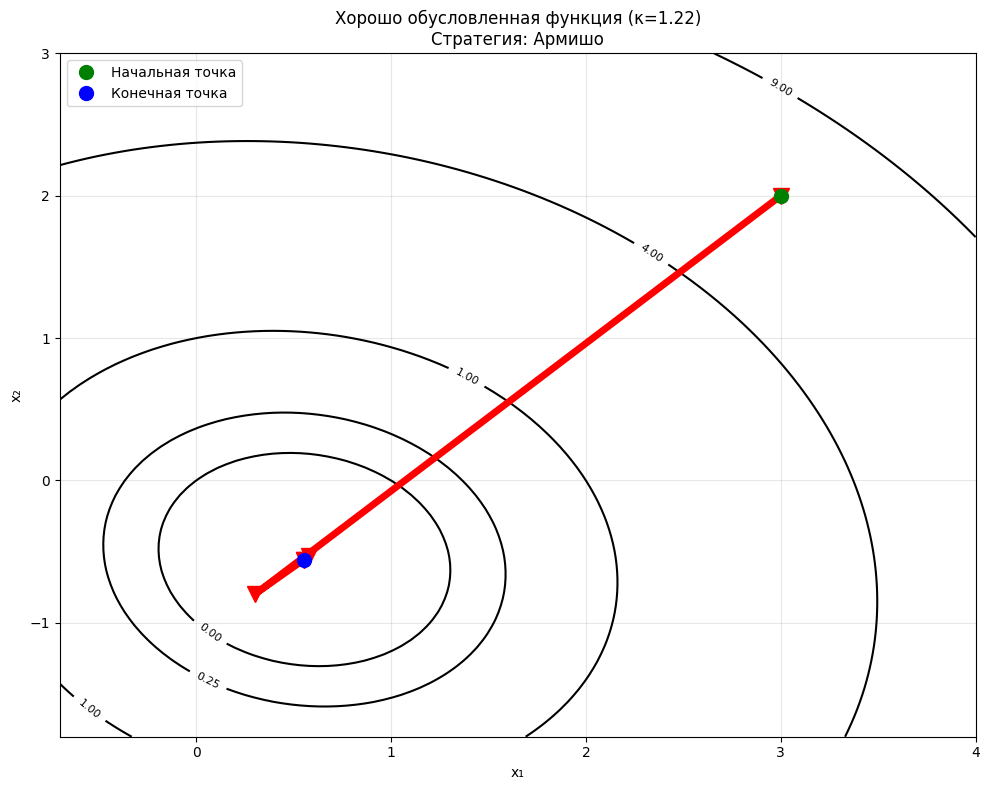


Пример 2: Плохо обусловленная функция (κ >> 1)
Число обусловленности: 100.0000
Iteration 0: f(x) = 39.450000, ||grad|| = 2.900845e+01
Iteration 1: f(x) = -0.032742, ||grad|| = 7.282879e+00, alpha = 0.125000
Iteration 2: f(x) = -2.555964, ||grad|| = 1.936779e+00, alpha = 0.125000
Iteration 3: f(x) = -2.767837, ||grad|| = 8.122203e-01, alpha = 0.125000
Iteration 4: f(x) = -2.833903, ||grad|| = 6.752212e-01, alpha = 0.125000
Iteration 5: f(x) = -2.889545, ||grad|| = 6.579400e-01, alpha = 0.125000
Iteration 6: f(x) = -2.943256, ||grad|| = 6.491521e-01, alpha = 0.125000
Iteration 7: f(x) = -2.995597, ||grad|| = 6.410021e-01, alpha = 0.125000
Iteration 8: f(x) = -3.046637, ||grad|| = 6.329873e-01, alpha = 0.125000
Iteration 9: f(x) = -3.096408, ||grad|| = 6.250748e-01, alpha = 0.125000
Iteration 10: f(x) = -3.144942, ||grad|| = 6.172613e-01, alpha = 0.125000
Iteration 11: f(x) = -3.192271, ||grad|| = 6.095456e-01, alpha = 0.125000
Iteration 12: f(x) = -3.238424, ||grad|| = 6.019263e-01, alp

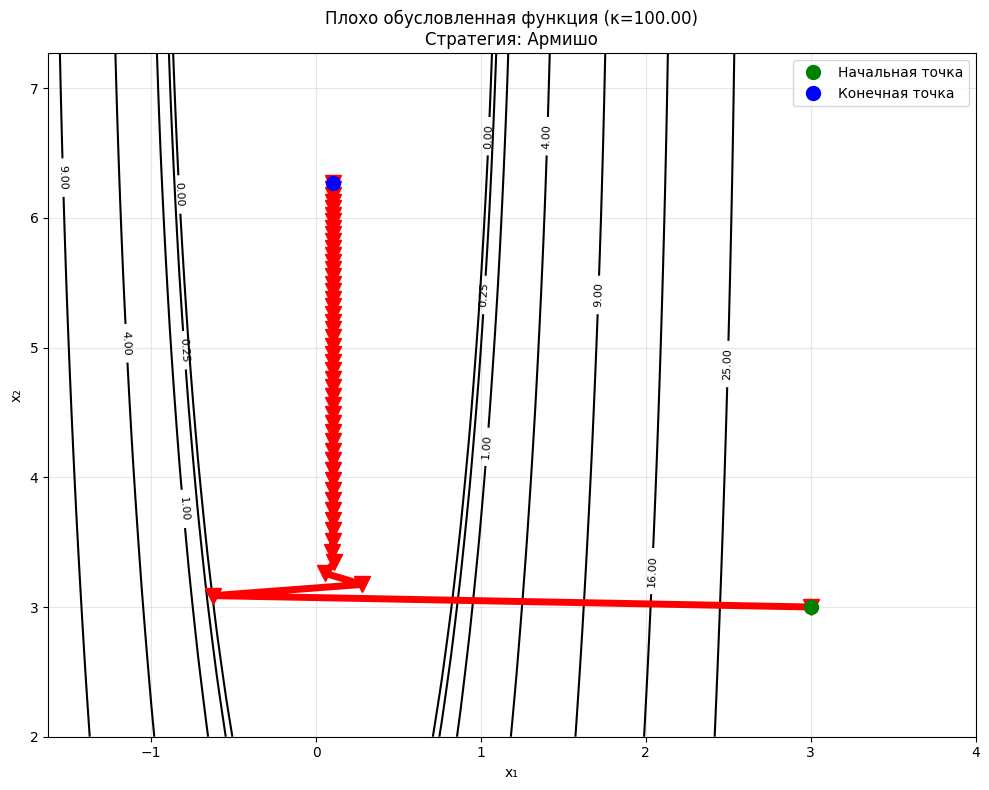


Пример 3: Сравнение стратегий выбора шага

--- Стратегия: Постоянный шаг ---
Результат: success
Всего итераций: 22
Финальное значение функции: -0.6999945642

--- Стратегия: Правило Армишо ---
Результат: iterations_exceeded
Всего итераций: 30
Финальное значение функции: -0.6999862641

--- Стратегия: Правило Вульфа ---
Результат: success
Всего итераций: 10
Финальное значение функции: -0.6999972831


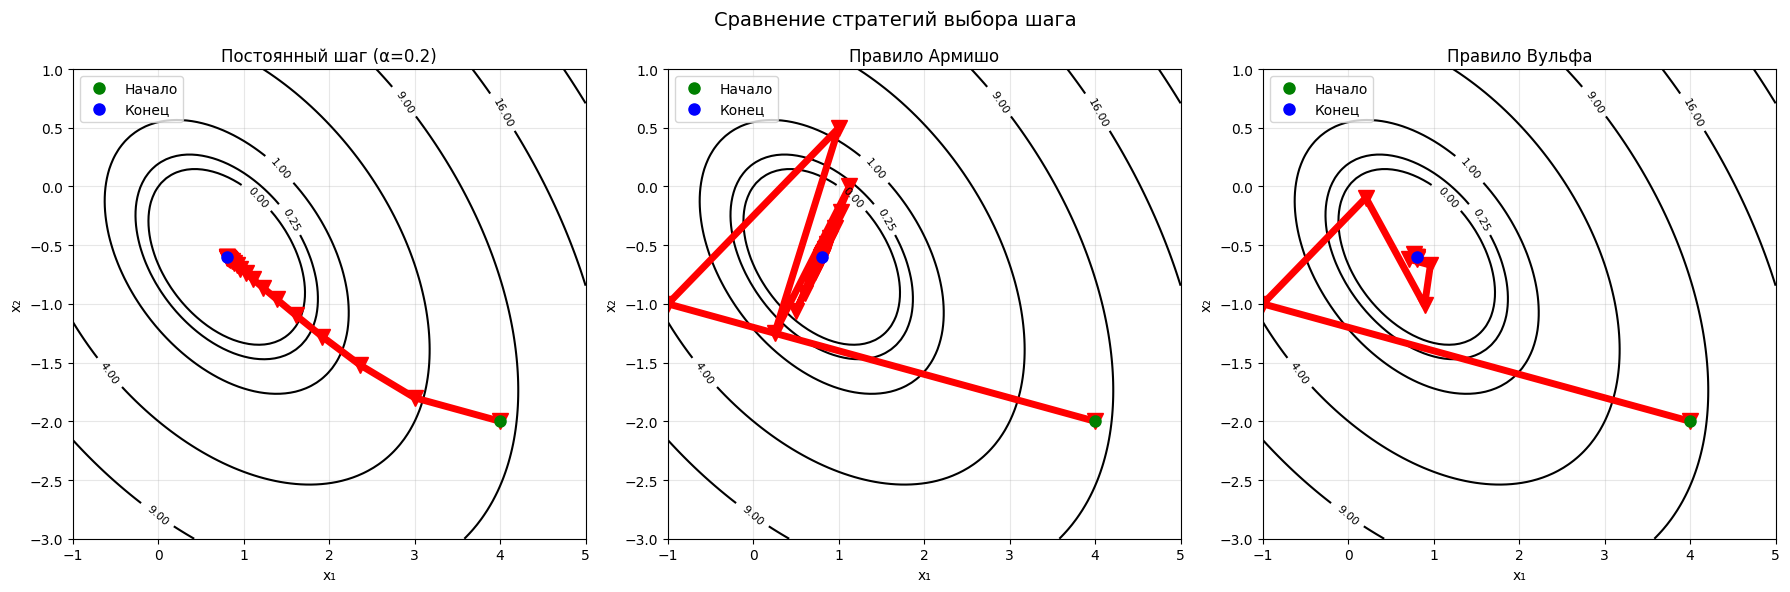


АНАЛИЗ СКОРОСТИ СХОДИМОСТИ:
Постоянный шаг:
  Итераций: 22
  Улучшение f(x): 8.699995
  Среднее улучшение за итерацию: 0.395454
  Финальная норма градиента: 3.876089e-03

Армишо:
  Итераций: 30
  Улучшение f(x): 8.699986
  Среднее улучшение за итерацию: 0.290000
  Финальная норма градиента: 9.969650e-03

Вульф:
  Итераций: 10
  Улучшение f(x): 8.699997
  Среднее улучшение за итерацию: 0.870000
  Финальная норма градиента: 2.860653e-03


АНАЛИЗ РЕЗУЛЬТАТОВ:
1. Хорошо обусловленные функции (κ ≈ 1):
   - Градиентный спуск сходится быстро
   - Траектория прямая или почти прямая
   - Различные стратегии шага работают хорошо

2. Плохо обусловленные функции (κ >> 1):
   - Сходимость замедляется
   - Траектория имеет 'зигзагообразный' вид
   - Адаптивные стратегии (Армишо, Вульф) работают лучше постоянных

3. Влияние стратегии выбора шага:
   - Постоянный шаг: прост в реализации, но требует подбора параметра
   - Правило Армишо: адаптивный, гарантирует сходимость
   - Условия Вульфа: более ст

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from optimization import gradient_descent, get_line_search_tool
from oracles import QuadraticOracle
from plot_trajectory_2d import plot_levels, plot_trajectory
import matplotlib

def run_gradient_descent_experiment(A, b, start_point, line_search_options=None,
                                   max_iterations=50, tolerance=1e-6, display_info=True):
    """
    Запуск градиентного спуска с использованием готовой реализации

    Параметры:
    A - матрица квадратичной формы
    b - вектор линейного члена
    start_point - начальная точка
    line_search_options - параметры линейного поиска
    max_iterations - максимальное число итераций
    tolerance - критерий остановки
    display_info - показывать ли информацию о ходе выполнения

    Возвращает:
    x_star - найденная точка минимума
    msg - сообщение о завершении
    history - история оптимизации
    """
    # Создаем оракул
    oracle = QuadraticOracle(A, b)

    # Запускаем градиентный спуск
    x_star, msg, history = gradient_descent(
        oracle=oracle,
        x_0=start_point,
        tolerance=tolerance,
        max_iter=max_iterations,
        line_search_options=line_search_options,
        trace=True,
        display=display_info
    )

    if display_info:
        print(f"\nРезультат: {msg}")
        print(f"Всего итераций: {len(history['func'])-1}")
        print(f"Финальная точка: {x_star}")
        print(f"Финальное значение функции: {oracle.func(x_star):.10f}")
        print(f"Норма градиента: {history['grad_norm'][-1]:.10f}")

    return x_star, msg, history

def visualize_optimization_path(oracle, history, title="Траектория оптимизации", xrange=None, yrange=None):
    """
    Визуализация линий уровня функции и траектории оптимизации

    Параметры:
    oracle - оракул функции
    history - история оптимизации
    title - заголовок графика
    xrange, yrange - диапазоны для осей
    """
    # Создаем график
    plt.figure(figsize=(10, 8))

    # Определяем диапазоны для линий уровня
    if xrange is None or yrange is None:
        points = np.array(history['x'])
        if len(points) > 0:
            x_min, x_max = points[:, 0].min() - 1, points[:, 0].max() + 1
            y_min, y_max = points[:, 1].min() - 1, points[:, 1].max() + 1
            xrange = [x_min, x_max]
            yrange = [y_min, y_max]
        else:
            xrange = [-5, 5]
            yrange = [-5, 5]

    # Линии уровня
    plot_levels(oracle.func, xrange=xrange, yrange=yrange)

    # Траектория оптимизации
    if len(history['x']) > 0:
        plot_trajectory(oracle.func, history['x'], fit_axis=False)

    # Начальная и конечная точки
    if len(history['x']) > 0:
        start_point = history['x'][0]
        end_point = history['x'][-1]
        plt.plot(start_point[0], start_point[1], 'go', markersize=10, label='Начальная точка')
        plt.plot(end_point[0], end_point[1], 'bo', markersize=10, label='Конечная точка')

    # Настройки графика
    plt.xlabel('x₁')
    plt.ylabel('x₂')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def analyze_condition_number_effect():
    """
    Анализ влияния числа обусловленности на траекторию градиентного спуска
    """
    np.random.seed(42)

    # Пример 1: Хорошо обусловленная функция (κ ≈ 1)
    print("\n" + "="*60)
    print("Пример 1: Хорошо обусловленная функция (κ ≈ 1)")
    print("="*60)

    A1 = np.array([[1.0, 0.1],
                   [0.1, 1.0]])
    b1 = np.array([0.5, -0.5])
    start1 = np.array([3.0, 2.0])

    # Вычисляем собственные значения для определения числа обусловленности
    eigenvalues1 = np.linalg.eigvals(A1)
    cond_number1 = eigenvalues1.max() / eigenvalues1.min()
    print(f"Число обусловленности: {cond_number1:.4f}")

    # Запускаем с правилом Армихо
    line_search_armijo = {'method': 'Armijo', 'c1': 1e-4, 'alpha_0': 1.0}
    x_star1, msg1, history1 = run_gradient_descent_experiment(
        A1, b1, start1,
        line_search_options=line_search_armijo,
        max_iterations=30
    )

    oracle1 = QuadraticOracle(A1, b1)
    visualize_optimization_path(
        oracle1, history1,
        f"Хорошо обусловленная функция (κ={cond_number1:.2f})\nСтратегия: Армишо"
    )

    # Пример 2: Плохо обусловленная функция (κ >> 1)
    print("\n" + "="*60)
    print("Пример 2: Плохо обусловленная функция (κ >> 1)")
    print("="*60)

    A2 = np.array([[10.0, 0.0],
                   [0.0, 0.1]])
    b2 = np.array([1.0, 1.0])
    start2 = np.array([3.0, 3.0])

    eigenvalues2 = np.linalg.eigvals(A2)
    cond_number2 = eigenvalues2.max() / eigenvalues2.min()
    print(f"Число обусловленности: {cond_number2:.4f}")

    x_star2, msg2, history2 = run_gradient_descent_experiment(
        A2, b2, start2,
        line_search_options=line_search_armijo,
        max_iterations=50
    )

    oracle2 = QuadraticOracle(A2, b2)
    visualize_optimization_path(
        oracle2, history2,
        f"Плохо обусловленная функция (κ={cond_number2:.2f})\nСтратегия: Армишо"
    )

    # Пример 3: Сравнение стратегий выбора шага
    print("\n" + "="*60)
    print("Пример 3: Сравнение стратегий выбора шага")
    print("="*60)

    A3 = np.array([[2.0, 1.0],
                   [1.0, 3.0]])
    b3 = np.array([1.0, -1.0])
    start3 = np.array([4.0, -2.0])

    # Постоянный шаг
    print("\n--- Стратегия: Постоянный шаг ---")
    line_search_constant = {'method': 'Constant', 'c': 0.2}
    x_star_const, msg_const, history_const = run_gradient_descent_experiment(
        A3, b3, start3,
        line_search_options=line_search_constant,
        max_iterations=30,
        display_info=False
    )

    print(f"Результат: {msg_const}")
    print(f"Всего итераций: {len(history_const['func'])-1}")
    print(f"Финальное значение функции: {QuadraticOracle(A3, b3).func(x_star_const):.10f}")

    # Правило Армишо
    print("\n--- Стратегия: Правило Армишо ---")
    x_star_armijo, msg_armijo, history_armijo = run_gradient_descent_experiment(
        A3, b3, start3,
        line_search_options=line_search_armijo,
        max_iterations=30,
        display_info=False
    )

    print(f"Результат: {msg_armijo}")
    print(f"Всего итераций: {len(history_armijo['func'])-1}")
    print(f"Финальное значение функции: {QuadraticOracle(A3, b3).func(x_star_armijo):.10f}")

    # Правило Вульфа
    print("\n--- Стратегия: Правило Вульфа ---")
    line_search_wolfe = {'method': 'Wolfe', 'c1': 1e-4, 'c2': 0.9, 'alpha_0': 1.0}
    x_star_wolfe, msg_wolfe, history_wolfe = run_gradient_descent_experiment(
        A3, b3, start3,
        line_search_options=line_search_wolfe,
        max_iterations=30,
        display_info=False
    )

    print(f"Результат: {msg_wolfe}")
    print(f"Всего итераций: {len(history_wolfe['func'])-1}")
    print(f"Финальное значение функции: {QuadraticOracle(A3, b3).func(x_star_wolfe):.10f}")

    # Визуализация сравнения
    oracle3 = QuadraticOracle(A3, b3)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Постоянный шаг
    ax1 = axes[0]
    plt.sca(ax1)
    plot_levels(oracle3.func, xrange=[-1, 5], yrange=[-3, 1])
    if len(history_const['x']) > 0:
        plot_trajectory(oracle3.func, history_const['x'], fit_axis=False)
        start_point = history_const['x'][0]
        end_point = history_const['x'][-1]
        plt.plot(start_point[0], start_point[1], 'go', markersize=8, label='Начало')
        plt.plot(end_point[0], end_point[1], 'bo', markersize=8, label='Конец')
    ax1.set_title('Постоянный шаг (α=0.2)')
    ax1.set_xlabel('x₁')
    ax1.set_ylabel('x₂')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Правило Армишо
    ax2 = axes[1]
    plt.sca(ax2)
    plot_levels(oracle3.func, xrange=[-1, 5], yrange=[-3, 1])
    if len(history_armijo['x']) > 0:
        plot_trajectory(oracle3.func, history_armijo['x'], fit_axis=False)
        start_point = history_armijo['x'][0]
        end_point = history_armijo['x'][-1]
        plt.plot(start_point[0], start_point[1], 'go', markersize=8, label='Начало')
        plt.plot(end_point[0], end_point[1], 'bo', markersize=8, label='Конец')
    ax2.set_title('Правило Армишо')
    ax2.set_xlabel('x₁')
    ax2.set_ylabel('x₂')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Правило Вульфа
    ax3 = axes[2]
    plt.sca(ax3)
    plot_levels(oracle3.func, xrange=[-1, 5], yrange=[-3, 1])
    if len(history_wolfe['x']) > 0:
        plot_trajectory(oracle3.func, history_wolfe['x'], fit_axis=False)
        start_point = history_wolfe['x'][0]
        end_point = history_wolfe['x'][-1]
        plt.plot(start_point[0], start_point[1], 'go', markersize=8, label='Начало')
        plt.plot(end_point[0], end_point[1], 'bo', markersize=8, label='Конец')
    ax3.set_title('Правило Вульфа')
    ax3.set_xlabel('x₁')
    ax3.set_ylabel('x₂')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    plt.suptitle('Сравнение стратегий выбора шага', fontsize=14)
    plt.tight_layout()
    plt.show()

    # Анализ скорости сходимости
    print("\n" + "="*60)
    print("АНАЛИЗ СКОРОСТИ СХОДИМОСТИ:")
    print("="*60)

    strategies = [
        ('Постоянный шаг', history_const),
        ('Армишо', history_armijo),
        ('Вульф', history_wolfe)
    ]

    for name, hist in strategies:
        if len(hist['func']) > 0:
            initial_func = hist['func'][0]
            final_func = hist['func'][-1]
            improvement = initial_func - final_func
            iterations = len(hist['func']) - 1
            print(f"{name}:")
            print(f"  Итераций: {iterations}")
            print(f"  Улучшение f(x): {improvement:.6f}")
            print(f"  Среднее улучшение за итерацию: {improvement/iterations:.6f}")
            print(f"  Финальная норма градиента: {hist['grad_norm'][-1]:.6e}")
            print()

    # Анализ результатов
    print("\n" + "="*60)
    print("АНАЛИЗ РЕЗУЛЬТАТОВ:")
    print("="*60)
    print("1. Хорошо обусловленные функции (κ ≈ 1):")
    print("   - Градиентный спуск сходится быстро")
    print("   - Траектория прямая или почти прямая")
    print("   - Различные стратегии шага работают хорошо")

    print("\n2. Плохо обусловленные функции (κ >> 1):")
    print("   - Сходимость замедляется")
    print("   - Траектория имеет 'зигзагообразный' вид")
    print("   - Адаптивные стратегии (Армишо, Вульф) работают лучше постоянных")

    print("\n3. Влияние стратегии выбора шага:")
    print("   - Постоянный шаг: прост в реализации, но требует подбора параметра")
    print("   - Правило Армишо: адаптивный, гарантирует сходимость")
    print("   - Условия Вульфа: более строгие, но могут требовать больше вычислений")

# Запуск эксперимента
if __name__ == "__main__":
    print("ЭКСПЕРИМЕНТ 3.1: Анализ траектории градиентного спуска")
    print("="*70)
    print("Цель: Исследовать поведение градиентного спуска на квадратичных функциях")
    print("в зависимости от числа обусловленности и стратегии выбора шага.")
    print("="*70)

    analyze_condition_number_effect()

## 3.2 Эксперимент: Зависимость числа итераций градиентного спуска от числа обусловленности и размерности пространства

Исследуйте, как зависит число итераций, необходимое градиентному спуску для сходимости, от сле-
дующих двух параметров: 1) числа обусловленности $κ ≥ 1$ оптимизируемой функции и 2) размерности
пространства $n$ оптимизируемых переменных.  

Для этого для заданных параметровnиκсгенерируйте случайным образом квадратичную задачу
размераnс числом обусловленностиκи запустите на ней градиентный спуск с некоторой фиксиро-
ванной требуемой точностью. Замерьте число итераций $T(n,κ)$, которое потребовалось сделать методу до сходимости (успешному выходу по критерию остановки).  

**Рекомендация:** Проще всего сгенерировать случайную квадратичную задачу размера $n$ с заданным числом обусловленности $κ$ следующим образом. В качестве матрицы $A∈S^n_{++}$ удобно взять просто диагональную матрицу $A= Diag(a)$, у которой диагональные элементы сгенерированы случайно
в пределах $[1,κ]$, причем $min(a) = 1, max(a) = κ$. В качестве вектора $b∈R^n$ можно взять вектор со случайными элементами. Диагональные матрицы удобно рассматривать, поскольку с ними можно эффективно работать даже при больших значениях $n$. Рекомендуется хранить матрицу $A$ в формате разреженной диагональной матрицы (см. `scipy.sparse.diags`).  

Зафиксируйте некоторое значение размерности $n$. Переберите различные числа обусловленности
$κ$ по сетке и постройте график зависимости $T(κ,n)$ против $κ$. Поскольку каждый раз квадратичная задача генерируется случайным образом, то повторите этот эксперимент несколько раз. В результате для фиксированного значения $n$ у Вас должно получиться целое семейство кривых зависимости $T(κ,n)$ от $κ$. Нарисуйте все эти кривые одним и тем же цветом для наглядности (например, красным).  

Теперь увеличьте значение $n$ и повторите эксперимент снова. Вы должны получить новое семейство
кривых $T(n′,κ)$ против $κ$. Нарисуйте их все одним и тем же цветом, но отличным от предыдущего
(например, синим).  

Повторите эту процедуру несколько раз для других значений $n$. В итоге должно получиться несколько разных семейств кривых - часть красных (соответствующих одному значению $n$), часть синих (соответствующих другому значению $n$), часть зеленых и т. д.  

Обратите внимание, что значения размерности $n$ имеет смысл перебирать по логарифмической
сетке (например, $n = 10, n = 100, n = 1000$ и т. д.).  

Какие выводы можно сделать из полученной картинки?

ЭКСПЕРИМЕНТ: Зависимость сходимости градиентного спуска
от числа обусловленности κ и размерности n
Размерности n: [10, 30, 100, 300]
Числа обусловленности κ: от 1.1 до 1000.0
Количество запусков на точку: 5
Директория для сохранения: experiment_results

Запуск экспериментов для n = 10


kappa для n=10: 100%|██████████| 15/15 [00:00<00:00, 25.76it/s]



Запуск экспериментов для n = 30


kappa для n=30: 100%|██████████| 15/15 [00:00<00:00, 24.26it/s]



Запуск экспериментов для n = 100


kappa для n=100: 100%|██████████| 15/15 [00:00<00:00, 27.71it/s]



Запуск экспериментов для n = 300


kappa для n=300: 100%|██████████| 15/15 [00:00<00:00, 23.72it/s]


График сохранен в experiment_results/main_results.png


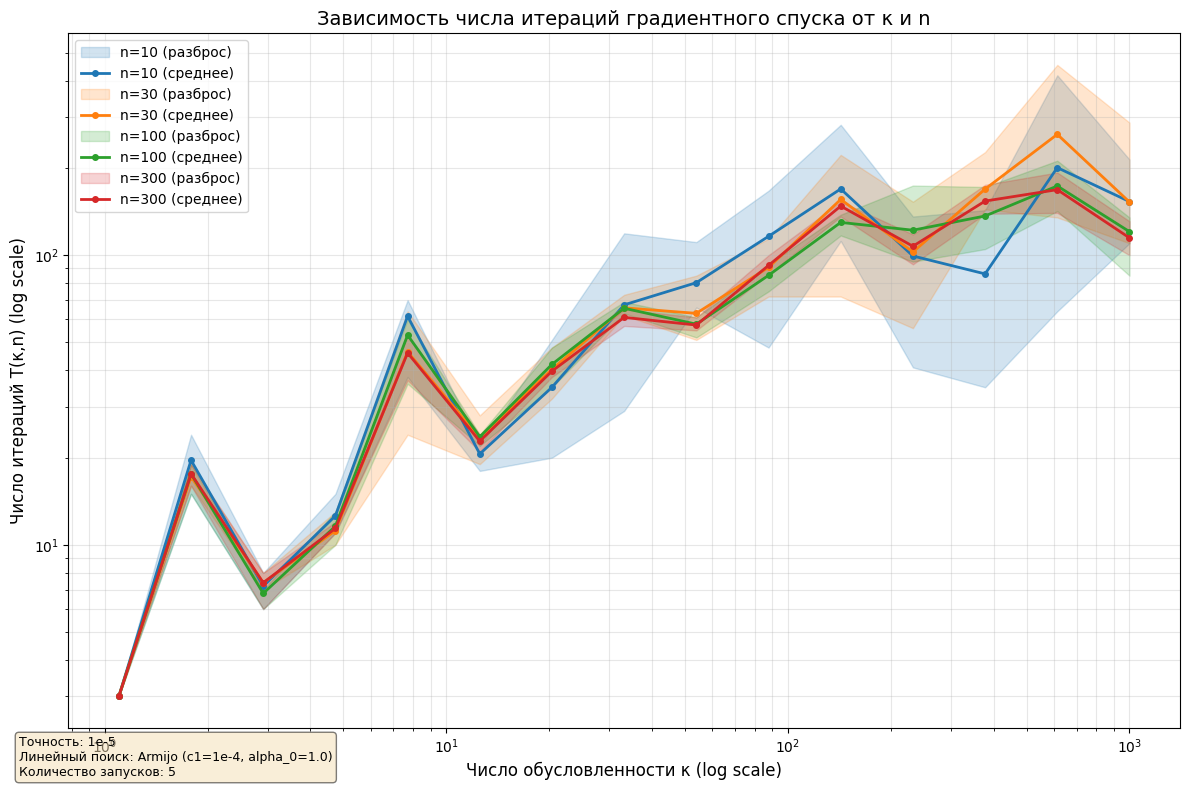

График сохранен в experiment_results/dimensionality_dependence.png


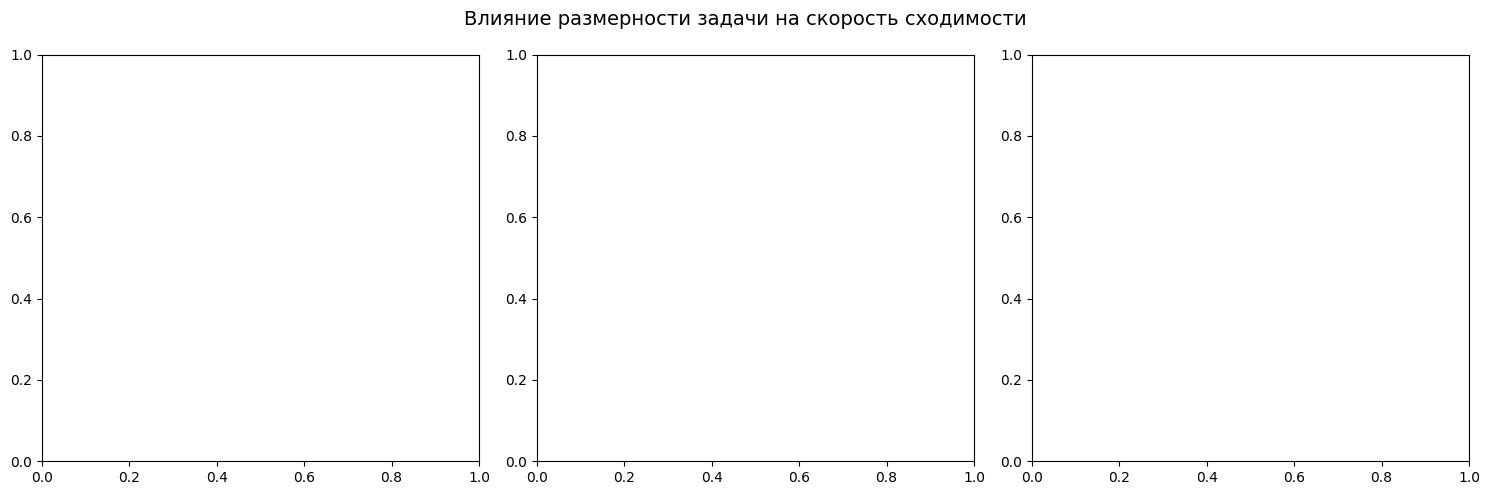

График траекторий сохранен в experiment_results/trajectories_kappa_comparison.png


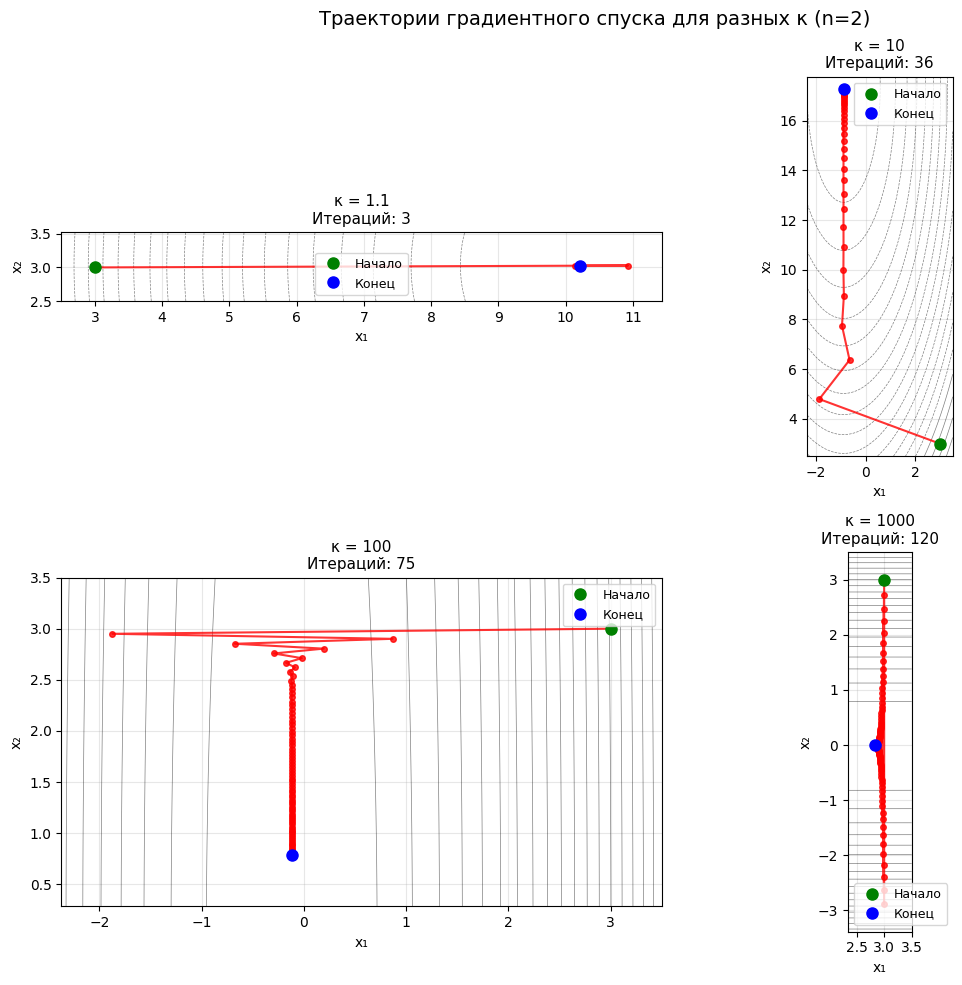


АНАЛИЗ СХОДИМОСТИ ГРАДИЕНТНОГО СПУСКА

Размерность n = 10:
----------------------------------------
  κ = 1.1:
    Среднее итераций: 3.0 ± 0.0
    Отношение T/κ: 2.73
  κ = 4.7:
    Среднее итераций: 12.6 ± 1.4
    Отношение T/κ: 2.66
  κ = 33.2:
    Среднее итераций: 67.4 ± 32.3
    Отношение T/κ: 2.03
  κ = 1000.0:
    Среднее итераций: 153.2 ± 45.4
    Отношение T/κ: 0.15

  Тренд по κ:
    Коэффициент в логарифмах: slope = 0.510
    Это соответствует T ∝ κ^0.510

Размерность n = 30:
----------------------------------------
  κ = 1.1:
    Среднее итераций: 3.0 ± 0.0
    Отношение T/κ: 2.73
  κ = 4.7:
    Среднее итераций: 11.2 ± 1.2
    Отношение T/κ: 2.37
  κ = 33.2:
    Среднее итераций: 65.8 ± 3.8
    Отношение T/κ: 1.98
  κ = 1000.0:
    Среднее итераций: 152.6 ± 67.4
    Отношение T/κ: 0.15

  Тренд по κ:
    Коэффициент в логарифмах: slope = 0.551
    Это соответствует T ∝ κ^0.551

Размерность n = 100:
----------------------------------------
  κ = 1.1:
    Среднее итераций: 

In [ ]:
# Эксперимент: Зависимость сходимости градиентного спуска от κ и n
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
from optimization import gradient_descent, get_line_search_tool
from oracles import QuadraticOracle
from plot_trajectory_2d import plot_levels, plot_trajectory
import warnings
from tqdm import tqdm

def generate_quadratic_problem(n, kappa, seed=None):
    """
    Генерирует случайную квадратичную задачу размера n с числом обусловленности kappa.

    Parameters:
    -----------
    n : int
        Размерность задачи
    kappa : float
        Число обусловленности (>= 1)
    seed : int, optional
        Seed для воспроизводимости

    Returns:
    --------
    oracle : QuadraticOracle
        Оракул для квадратичной функции
    """
    if seed is not None:
        np.random.seed(seed)

    # Генерируем диагональные элементы в пределах [1, kappa]
    a = np.ones(n)
    if n > 1:
        # Равномерно распределяем собственные значения в логарифмической шкале
        log_eigenvalues = np.linspace(0, np.log(kappa), n)
        a = np.exp(log_eigenvalues)
    else:
        a[0] = kappa

    # Перемешиваем для случайного порядка
    np.random.shuffle(a)

    # Создаем диагональную матрицу A
    A = scipy.sparse.diags(a, format='dia')

    # Генерируем случайный вектор b
    b = np.random.randn(n) * 10

    return QuadraticOracle(A, b), A, b

def run_gradient_descent_experiment(n_values, kappa_values, n_runs=5, tolerance=1e-5, max_iter=10000):
    """
    Проводит эксперимент по зависимости числа итераций от n и kappa.
    """
    results = {n: {kappa: [] for kappa in kappa_values} for n in n_values}

    for n in n_values:
        print(f"\nЗапуск экспериментов для n = {n}")

        for kappa in tqdm(kappa_values, desc=f"kappa для n={n}"):
            for run in range(n_runs):
                # Генерируем задачу
                oracle, A, b = generate_quadratic_problem(n, kappa, seed=run*1000 + int(kappa))

                # Начальная точка - случайная
                x0 = np.random.randn(n) * 10

                # Запускаем градиентный спуск
                line_search_options = {
                    'method': 'Armijo',
                    'c1': 1e-4,
                    'alpha_0': 1.0
                }

                try:
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        x_star, message, history = gradient_descent(
                            oracle=oracle,
                            x_0=x0,
                            tolerance=tolerance,
                            max_iter=max_iter,
                            line_search_options=line_search_options,
                            trace=True,
                            display=False
                        )

                    if message == 'success' and history is not None:
                        n_iterations = len(history['func']) - 1
                        results[n][kappa].append(n_iterations)
                    else:
                        results[n][kappa].append(max_iter)

                except Exception as e:
                    print(f"Ошибка для n={n}, kappa={kappa}, run={run}: {e}")
                    results[n][kappa].append(max_iter)

    return results

def plot_results(results, kappa_values, colors=None, save_path=None):
    """
    Визуализирует результаты эксперимента.
    """
    if colors is None:
        cmap = plt.cm.tab10
        n_colors = len(results)
        colors = {list(results.keys())[i]: cmap(i) for i in range(n_colors)}

    plt.figure(figsize=(12, 8))

    for n in results.keys():
        means = []
        mins = []
        maxs = []

        for kappa in kappa_values:
            iterations = results[n][kappa]
            if iterations:
                means.append(np.mean(iterations))
                mins.append(np.min(iterations))
                maxs.append(np.max(iterations))
            else:
                means.append(np.nan)
                mins.append(np.nan)
                maxs.append(np.nan)

        # Область разброса
        plt.fill_between(kappa_values, mins, maxs,
                        alpha=0.2, color=colors[n],
                        label=f'n={n} (разброс)')

        # Средняя кривая
        plt.plot(kappa_values, means, 'o-', linewidth=2,
                color=colors[n], markersize=4,
                label=f'n={n} (среднее)')

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Число обусловленности κ (log scale)', fontsize=12)
    plt.ylabel('Число итераций T(κ,n) (log scale)', fontsize=12)
    plt.title('Зависимость числа итераций градиентного спуска от κ и n', fontsize=14)
    plt.grid(True, alpha=0.3, which='both')
    plt.legend(loc='best', fontsize=10)

    experiment_info = f"Точность: 1e-5\nЛинейный поиск: Armijo (c1=1e-4, alpha_0=1.0)\nКоличество запусков: 5"
    plt.figtext(0.02, 0.02, experiment_info, fontsize=9,
                verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"График сохранен в {save_path}")

    plt.show()

def analyze_convergence_rate(results, kappa_values):
    """
    Анализирует скорость сходимости в зависимости от κ.
    """
    print("\n" + "="*60)
    print("АНАЛИЗ СХОДИМОСТИ ГРАДИЕНТНОГО СПУСКА")
    print("="*60)

    for n in results.keys():
        print(f"\nРазмерность n = {n}:")
        print("-"*40)

        # Выбираем несколько значений kappa для анализа
        kappa_sample_indices = [0, len(kappa_values)//4, len(kappa_values)//2, -1]

        for idx in kappa_sample_indices:
            if idx < len(kappa_values):
                kappa = kappa_values[idx]
                iterations = results[n][kappa]

                if iterations:
                    avg_iter = np.mean(iterations)
                    std_iter = np.std(iterations)

                    print(f"  κ = {kappa:.1f}:")
                    print(f"    Среднее итераций: {avg_iter:.1f} ± {std_iter:.1f}")
                    print(f"    Отношение T/κ: {avg_iter/kappa:.2f}")

        # Анализ тренда
        print(f"\n  Тренд по κ:")
        valid_kappas = []
        valid_means = []

        for kappa in kappa_values:
            if results[n][kappa]:
                valid_kappas.append(kappa)
                valid_means.append(np.mean(results[n][kappa]))

        if len(valid_kappas) > 2:
            log_kappa = np.log(valid_kappas)
            log_T = np.log(valid_means)

            slope, intercept = np.polyfit(log_kappa, log_T, 1)

            print(f"    Коэффициент в логарифмах: slope = {slope:.3f}")
            print(f"    Это соответствует T ∝ κ^{slope:.3f}")

def plot_dimensionality_dependence(results, kappa_sample=[10, 100, 500], save_path=None):
    """
    Анализирует зависимость от размерности n при фиксированных κ.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for idx, kappa in enumerate(kappa_sample):
        ax = axes[idx]

        n_list = []
        iter_list = []

        for n in results.keys():
            if kappa in results[n] and results[n][kappa]:
                avg_iter = np.mean(results[n][kappa])
                n_list.append(n)
                iter_list.append(avg_iter)

        if n_list:
            ax.plot(n_list, iter_list, 'o-', linewidth=2, markersize=8)
            ax.set_xlabel('Размерность n', fontsize=11)
            ax.set_ylabel('Среднее число итераций', fontsize=11)
            ax.set_title(f'Зависимость от n при κ = {kappa}', fontsize=12)
            ax.grid(True, alpha=0.3)

            # Линейная регрессия для оценки зависимости
            if len(n_list) > 1:
                coeffs = np.polyfit(n_list, iter_list, 1)
                x_fit = np.array([min(n_list), max(n_list)])
                y_fit = coeffs[0] * x_fit + coeffs[1]
                ax.plot(x_fit, y_fit, 'r--', alpha=0.7,
                       label=f'Наклон: {coeffs[0]:.2f}')
                ax.legend()

    plt.suptitle('Влияние размерности задачи на скорость сходимости', fontsize=14)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"График сохранен в {save_path}")

    plt.show()

def visualize_sample_trajectories(n=2, kappa_values=[1.1, 10, 100, 1000], save_dir=None):
    """
    Визуализирует траектории градиентного спуска для 2D примеров.
    """
    n_plots = len(kappa_values)
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for idx, kappa in enumerate(kappa_values):
        if idx >= len(axes):
            break

        ax = axes[idx]

        # Генерируем 2D задачу
        oracle, A, b = generate_quadratic_problem(n, kappa, seed=idx*100)

        # Начальная точка
        x0 = np.array([3.0, 3.0])

        # Запускаем градиентный спуск
        line_search_options = {
            'method': 'Armijo',
            'c1': 1e-4,
            'alpha_0': 1.0
        }

        x_star, message, history = gradient_descent(
            oracle=oracle,
            x_0=x0,
            tolerance=1e-5,
            max_iter=1000,
            line_search_options=line_search_options,
            trace=True,
            display=False
        )

        # Визуализация
        if history and 'x' in history:
            # Определяем диапазон для графиков
            points = np.array(history['x'])
            x_min, x_max = points[:, 0].min() - 0.5, points[:, 0].max() + 0.5
            y_min, y_max = points[:, 1].min() - 0.5, points[:, 1].max() + 0.5

            # Рисуем линии уровня
            x = np.linspace(x_min, x_max, 100)
            y = np.linspace(y_min, y_max, 100)
            X, Y = np.meshgrid(x, y)
            Z = np.zeros(X.shape)

            for i in range(Z.shape[0]):
                for j in range(Z.shape[1]):
                    Z[i, j] = oracle.func(np.array([X[i, j], Y[i, j]]))

            # Линии уровня
            levels = np.linspace(Z.min(), Z.max(), 20)
            contour = ax.contour(X, Y, Z, levels=levels, colors='k', alpha=0.5, linewidths=0.5)

            # Траектория
            traj_points = np.array(history['x'])
            ax.plot(traj_points[:, 0], traj_points[:, 1], 'ro-',
                   linewidth=1.5, markersize=4, alpha=0.8)
            ax.plot(traj_points[0, 0], traj_points[0, 1], 'go',
                   markersize=8, label='Начало')
            ax.plot(traj_points[-1, 0], traj_points[-1, 1], 'bo',
                   markersize=8, label='Конец')

            ax.set_title(f'κ = {kappa}\nИтераций: {len(history["func"])-1}', fontsize=11)
            ax.set_xlabel('x₁')
            ax.set_ylabel('x₂')
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=9)
            ax.set_aspect('equal')

    plt.suptitle('Траектории градиентного спуска для разных κ (n=2)', fontsize=14)
    plt.tight_layout()

    if save_dir:
        save_path = f"{save_dir}/trajectories_kappa_comparison.png"
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"График траекторий сохранен в {save_path}")

    plt.show()

def main():
    """
    Основная функция для запуска эксперимента.
    """
    import os

    # Создаем директорию для сохранения графиков
    save_dir = "experiment_results"
    os.makedirs(save_dir, exist_ok=True)

    # Параметры эксперимента
    n_values = [10, 30, 100, 300]
    kappa_values = np.geomspace(1.1, 1000, 15)
    n_runs = 5

    print("="*60)
    print("ЭКСПЕРИМЕНТ: Зависимость сходимости градиентного спуска")
    print("от числа обусловленности κ и размерности n")
    print("="*60)
    print(f"Размерности n: {n_values}")
    print(f"Числа обусловленности κ: от {kappa_values[0]:.1f} до {kappa_values[-1]:.1f}")
    print(f"Количество запусков на точку: {n_runs}")
    print(f"Директория для сохранения: {save_dir}")
    print("="*60)

    # Запускаем эксперимент
    results = run_gradient_descent_experiment(
        n_values=n_values,
        kappa_values=kappa_values,
        n_runs=n_runs,
        tolerance=1e-5,
        max_iter=10000
    )

    # 1. Основной график: зависимость от κ и n
    plot_results(results, kappa_values,
                 save_path=f"{save_dir}/main_results.png")

    # 2. График зависимости от размерности
    plot_dimensionality_dependence(results,
                                   save_path=f"{save_dir}/dimensionality_dependence.png")

    # 3. Визуализация траекторий для 2D случаев
    visualize_sample_trajectories(
        n=2,
        kappa_values=[1.1, 10, 100, 1000],
        save_dir=save_dir
    )

    # Анализируем результаты
    analyze_convergence_rate(results, kappa_values)

    # Дополнительный анализ
    print("\n" + "="*60)
    print("ЗАВИСИМОСТЬ ОТ РАЗМЕРНОСТИ n")
    print("="*60)

    kappa_sample = [10, 100, 500]

    for kappa in kappa_sample:
        print(f"\nДля κ = {kappa}:")
        print("n\tСреднее итераций\tОтношение T/n")
        print("-"*40)

        for n in n_values:
            if kappa in results[n] and results[n][kappa]:
                avg_iter = np.mean(results[n][kappa])
                print(f"{n}\t{avg_iter:.1f}\t\t\t{avg_iter/n:.2f}")

    # Сохраняем данные эксперимента
    import pickle
    data_path = f"{save_dir}/experiment_data.pkl"
    with open(data_path, 'wb') as f:
        pickle.dump({
            'n_values': n_values,
            'kappa_values': kappa_values,
            'results': results,
            'n_runs': n_runs
        }, f)

    print(f"\nДанные эксперимента сохранены в {data_path}")
    print("\nЭксперимент завершен успешно!")

if __name__ == "__main__":
    main()

## 3.3 Эксперимент: Сравнение методов градиентного спуска и Ньютона на реальной задаче логистической регрессии

Сравнить методы градиентного спуска и Ньютона на задаче обучения логистической регрессии на
реальных данных.

В качестве реальных данных используйте следующие три набора с сайта LIBSVM [http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/.](http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/.)
: *w8a*, *gisette* и *real-sim*. Коэффициент регуляризации взять стандартным образом: $λ = 1/m$.
Параметры обоих методов взять равными параметрам по умолчанию. Начальную точку выбрать
$x_0 = 0$.

Построить графики сходимости следующих двух видов:  
1) Зависимость значения функции от реального времени работы метода.  
2) Зависимость относительного квадрата нормы градиента $‖∇f(x_k)‖^2_2 /‖∇f(x_0)‖^2_2$ (в логарифмической шкале) против реального времени работы.

При этом оба метода (градиентный спуск и Ньютон) нужно рисовать на одном и том же графике.
Укажите в отчете, какова стоимость итерации и сколько памяти требуется каждому из методов в
зависимости от параметров $m$ (размер выборки) и $n$ (размерность пространства). При оценке используйте нотацию $O(·)$, скрывающую внутри себя абсолютные константы.

Какие выводы можно сделать по результатам этого эксперимента? Какой из методов лучше и в
каких ситуациях?

**Рекомендация:** Любой набор данных с сайта LIBSVM представляет из себя текстовый файл в фор-
мате svmlight. Чтобы считать такой текстовый файл, можно использовать функцию `load_svmlight_file` из модуля `sklearn.datasets`. Обратите внимание, что эта функция возвращает матрицу в формате `scipy.sparse.csr_matrix`, поэтому Ваша реализация логистического оракула должна поддерживать такие матрицы.

<!-- ## 3.4 (Бонусная часть) Эксперимент: Оптимизация вычислений в градиентном спуске

Сравнить градиентный спуск на логистической регрессии для обычного оракула и оптимизирован-
ного.
В качестве выборки использовать модельную с размерамиm= 10000,n= 8000. Пример генерации
модельной выборки из стандартного нормального распределения:

np.random.seed(31415)
m, n = 10000, 8000
A = np.random.randn(m, n)
b = np.sign(np.random.randn(m))

Коэффициент регуляризации выбрать стандартнымλ= 1/m.
Параметры метода взять равными параметрам по умолчанию. Начальную точку выбратьx 0 = 0.
Нарисовать графики:

```
(a) Зависимость значения функции от номера итерации.
```
```
(b) Зависимость значения функции от реального времени работы метода.
```
```
(c) Зависимость относительного квадрата нормы градиента‖∇f(xk)‖^22 /‖∇f(x 0 )‖^22 (в логарифмиче-
ской шкале) против реального времени работы.
```
При этом оба метода (с обычным оракулом и с оптимизированным) нужно рисовать на одном и том
же графике.
Объясните, почему траектории обоих методов на первом графике совпадают.


 -->

<!--
## 3.5 (Бонусная часть) Эксперимент: Стратегия выбора длины шага в градиентном спуске

Исследовать, как зависит поведение метода от стратегии подбора шага: константный шаг (попро-
бовать различные значения), бэктрэкинг (попробовать различные константыc), условия Вульфа (по-
пробовать различные параметрыc 2 ).
Рассмотрите квадратичную функцию и логистическую регрессию с модельными данным (сгенери-
рованными случайно).
Запустите для этих функций градиентный спуск с разными стратегиями выбора шагаиз одной и
той же начальной точки.
Нарисуйте кривые сходимости (относительная невязка по функции в логарифмической шкале про-
тив числа итераций – для квадратичной функции, относительный квадрат нормы градиента в лога-
рифмической шкале против числа итераций – для логистической регрессии) для разных стратегий на
одномграфике.
Попробуйте разные начальные точки. Ответьте на вопрос:Какая стратегия выбора шага является
самой лучшей?

 -->

# 4 Оформление задания

Результатом выполнения задания являются  
1) Файлы `optimization.py` и `oracles.py` с реализованными методами и оракулами.  
2) Полные исходные коды для проведения экспериментов и рисования всех графиков. Все результаты должны быть воспроизводимыми. Если вы используете случайность - зафиксируйте `seed`.  
3) Отчет в формате `.ipynb` о проведенных исследованиях.  

Каждый проведенный эксперимент следует оформить в виде отчёта в виде одного `.ipynb` документа (название раздела - название соответствующего эксперимента). Для каждого эксперимента необходимо
сначала написать его описание: какие функции оптимизируются, каким образом генерируются данные,
какие методы и с какими параметрами используются. Далее должны быть представлены результаты
соответствующего эксперимента - графики, таблицы и т. д. Наконец, после результатов эксперимента
должны быть написаны Ваши выводы - какая зависимость наблюдается и почему.

**Важно:** Отчет не должен содержать минимум кода. Каждый график должен быть прокомментирован - что на нем изображено, какие выводы можно сделать из этого эксперимента. Обязательно
должны быть подписаны оси. Если на графике нарисовано несколько кривых, то должна быть легенда.
Сами линии следует рисовать достаточно толстыми, чтобы они были хорошо видимыми.

# 5 Проверка задания

Перед отправкой задания обязательно убедитесь, что Ваша реализация проходит автоматические
предварительныетесты `presubmit_tests.py`, выданные вместе с заданием. Для этого запустите следующую команду:
```
>>> nosetests3 presubmit_tests.py
```

<!-- (b) Для бонусной части (проверяются как базовые, так и бонусные тесты):
nosetests3 presubmit_tests.py -a ’bonus’
 -->

**Важно:** Решения, которые не будут проходить тесты `presubmit_tests.py`, будут автоматически
оценены в **0 баллов**. Проверяющий не будет разбираться, почему Ваш код не работает и читать Ваш
отчет.
Оценка за задание будет складываться из двух частей:

1) Правильность и эффективность реализованного кода.
2) Качество отчета

Правильность и эффективность реализованного кода будет оцениваться автоматически с помощью
независимых тестов (отличных от предварительных тестов). Качество отчета будет оцениваться про-
веряющим. При этом оценка может быть субъективной и аппеляции не подлежит.

За реализацию модификаций алгоритмов и хорошие дополнительные эксперименты могут быть
начислены дополнительные баллы. Начисление этих баллов является субъективным и безапелляцион-
ным.

**Важно:** Практическое задание выполняется самостоятельно. Если вы получили ценные советы (по
реализации или проведению экспериментов) от другого студента, то об этом должно быть явно напи-
сано в отчёте. В противном случае "похожие" решения считаются плагиатом и все задействованные
студенты (в том числе те, у кого списали) будут сурово наказаны.




Эксперимент 3.3: Сравнение методов на реальных данных

Датасеты для тестирования:
  1. w8a        (m=49,749, n=300)
  2. gisette    (m=6,000, n=5,000)
  3. real-sim   (m=72,309, n=20,958)

Эксперимент 3.3: w8a
Датасет 'w8a' загружен:
  Образцы: 49749, Признаки: 300
  Классы: {np.float64(1.0), np.float64(-1.0)}

Статистика датасета:
  m (образцы) = 49,749
  n (признаки) = 300
  λ (regcoef) = 0.000020

Начальная норма градиента: ||∇f(x0)|| = 5.625363e-01
Критерий остановки: ||∇f(xk)|| ≤ 1e-05 * 5.625363e-01 = 5.625363e-06

Градиентный спуск
----------------------------------------
  Статус: success
  Время: 1.42 секунд
  Итераций: 36
  Финальное f(x): 1.370698e-01
  Финальная ||∇f(x)||: 1.687305e-03
  Отношение: ||∇f(x)||/||∇f(x0)|| = 2.999459e-03

Метод Ньютона
----------------------------------------
  Статус: success
  Время: 0.75 секунд
  Итераций: 7
  Финальное f(x): 1.270855e-01
  Финальная ||∇f(x)||: 1.122631e-03
  Отношение: ||∇f(x)||/||∇f(x0)|| = 1.995659e-03
  График сохранен: 

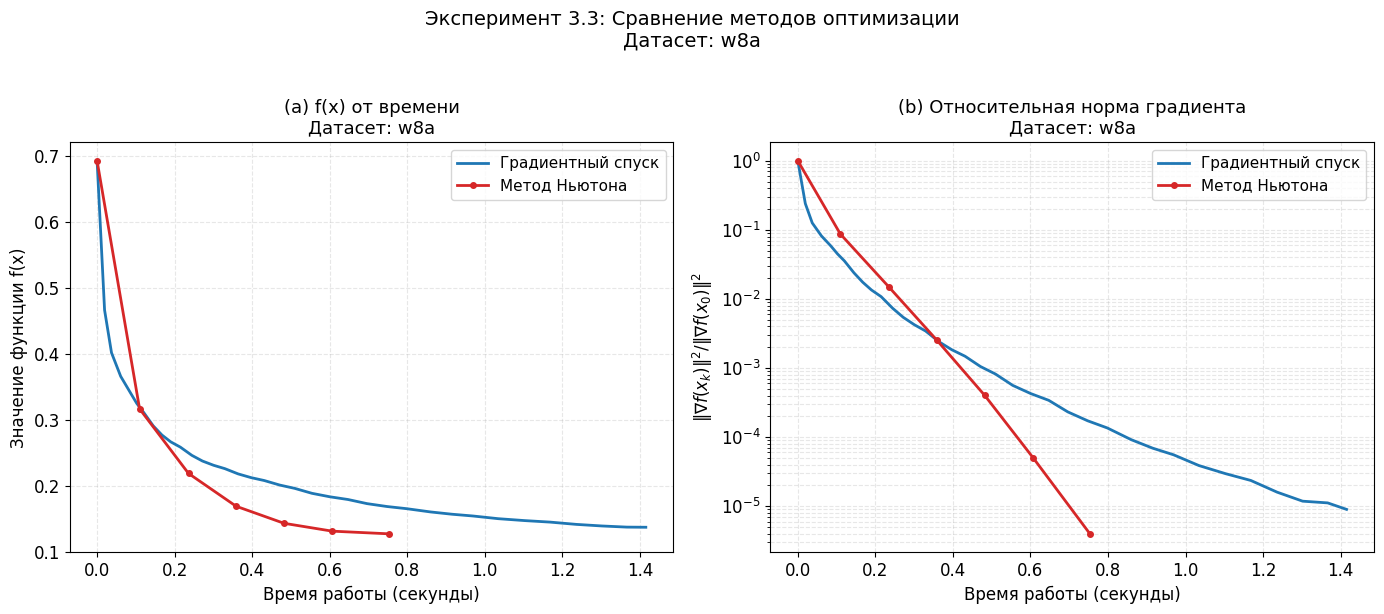


Эксперимент 3.3: gisette
Датасет 'gisette' загружен:
  Образцы: 6000, Признаки: 5000
  Классы: {np.float64(1.0), np.float64(-1.0)}

Статистика датасета:
  m (образцы) = 6,000
  n (признаки) = 5,000
  λ (regcoef) = 0.000167

Начальная норма градиента: ||∇f(x0)|| = 2.556089e+00
Критерий остановки: ||∇f(xk)|| ≤ 1e-05 * 2.556089e+00 = 2.556089e-05

Градиентный спуск
----------------------------------------
  Статус: success
  Время: 1234.90 секунд
  Итераций: 1968
  Финальное f(x): 1.047167e-02
  Финальная ||∇f(x)||: 8.007953e-03
  Отношение: ||∇f(x)||/||∇f(x0)|| = 3.132893e-03

Метод Ньютона
----------------------------------------


In [ ]:
"""
Эксперимент 3.3:
   Тестирование методов градиентного спуска и Ньютона на реальных данных из LIBSVM
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime
import time
import warnings
from sklearn.datasets import load_svmlight_file

# Импорт реализаций
from oracles import create_log_reg_oracle
from optimization import gradient_descent, newton

warnings.filterwarnings('ignore')

def load_libsvm_data(dataset_name, data_dir="./data"):
    """
    Загрузка данных из LIBSVM
    """
    file_paths = {
        'w8a': f'{data_dir}/w8a.txt',
        'gisette': f'{data_dir}/gisette_scale',
        'real-sim': f'{data_dir}/real-sim'}

    dataset_path = file_paths[dataset_name]

    try:
        # Загрузка данных
        A, b = load_svmlight_file(dataset_path)

        # Преобразование меток в {-1, 1}
        if set(b) == {0, 1}:
            b = 2 * b - 1
        elif set(b) == {-1, 1}:
            pass  # Уже в нужном формате
        else:
            # Для многоклассовых датасетов берём только два класса
            unique_classes = np.unique(b)
            if len(unique_classes) > 2:
                # Бинаризация: первый класс против остальных
                b = np.where(b == unique_classes[0], 1, -1)

        print(f"Датасет '{dataset_name}' загружен:")
        print(f"  Образцы: {A.shape[0]}, Признаки: {A.shape[1]}")
        print(f"  Классы: {set(b)}")

        return A, b

    except FileNotFoundError:
        print(f"Файл {dataset_path} не найден.")
        print("Скачайте датасеты и поместите в директорию data/")
        return None, None

def run_optimization_experiment(dataset_name, method='both'):
    """
    Запуск оптимизации
    """
    print(f"\n{'='*60}")
    print(f"Эксперимент 3.3: {dataset_name}")
    print('='*60)

    # Загрузка данных
    A, b = load_libsvm_data(dataset_name)
    if A is None:
        return None

    m, n = A.shape
    print(f"\nСтатистика датасета:")
    print(f"  m (образцы) = {m:,}")
    print(f"  n (признаки) = {n:,}")

    # Коэффициент регуляризации λ = 1/m
    regcoef = 1.0 / m
    print(f"  λ (regcoef) = {regcoef:.6f}")

    # Создание оракула
    oracle = create_log_reg_oracle(A, b, regcoef, oracle_type='usual')

    # Начальная точка x0 = 0
    x0 = np.zeros(n)

    # Параметры методов
    # Относительная точность ε = 1e-5
    epsilon = 1e-5
    max_iter_gd = 10000
    max_iter_newton = 100

    # Параметры линейного поиска по умолчанию (условия Вульфа)
    line_search_options = {'method': 'Wolfe'}

    results = {}

    # Вычисляем начальную норму градиента для относительного критерия
    grad_x0 = oracle.grad(x0)
    grad_norm_x0 = np.linalg.norm(grad_x0)
    print(f"\nНачальная норма градиента: ||∇f(x0)|| = {grad_norm_x0:.6e}")
    print(f"Критерий остановки: ||∇f(xk)|| ≤ {epsilon} * {grad_norm_x0:.6e} = {epsilon * grad_norm_x0:.6e}")

    # Функция для проверки критерия остановки
    def check_stopping_criterion(grad_norm):
        return grad_norm <= epsilon * grad_norm_x0

    # Запуск градиентного спуска
    if method in ['gd', 'both']:
        print(f"\nГрадиентный спуск")
        print("-" * 40)

        gd_start = time.time()

        # Запускаем градиентный спуск
        x_gd, status_gd, history_gd = gradient_descent(
            oracle=oracle,
            x_0=x0,
            tolerance=epsilon,  # Относительная точность
            max_iter=max_iter_gd,
            line_search_options=line_search_options,
            trace=True,
            display=False)

        gd_time = time.time() - gd_start

        # Обрабатываем историю
        if history_gd:
            # Проверяем критерий остановки для каждой итерации
            for i in range(len(history_gd['grad_norm'])):
                if check_stopping_criterion(history_gd['grad_norm'][i]):
                    # Обрезаем историю до момента достижения критерия
                    for key in history_gd:
                        history_gd[key] = history_gd[key][:i+1]
                    break

        print(f"  Статус: {status_gd}")
        print(f"  Время: {gd_time:.2f} секунд")
        print(f"  Итераций: {len(history_gd['func']) if history_gd else 0}")

        if history_gd and len(history_gd['func']) > 0:
            final_func = history_gd['func'][-1]
            final_grad_norm = history_gd['grad_norm'][-1]
            print(f"  Финальное f(x): {final_func:.6e}")
            print(f"  Финальная ||∇f(x)||: {final_grad_norm:.6e}")
            print(f"  Отношение: ||∇f(x)||/||∇f(x0)|| = {final_grad_norm/grad_norm_x0:.6e}")

        results['gd'] = {
            'x': x_gd,
            'status': status_gd,
            'history': history_gd,
            'time': gd_time,
            'iterations': len(history_gd['func']) if history_gd else 0}

    # Запуск метода Ньютона
    if method in ['newton', 'both']:
        print(f"\nМетод Ньютона")
        print("-" * 40)

        newton_start = time.time()

        # Запускаем метод Ньютона
        x_newton, status_newton, history_newton = newton(
            oracle=oracle,
            x_0=x0,
            tolerance=epsilon,  # Относительная точность
            max_iter=max_iter_newton,
            line_search_options=line_search_options,
            trace=True,
            display=False)

        newton_time = time.time() - newton_start

        # Обрабатываем историю
        if history_newton:
            # Проверяем критерий остановки для каждой итерации
            for i in range(len(history_newton['grad_norm'])):
                if check_stopping_criterion(history_newton['grad_norm'][i]):
                    # Обрезаем историю до момента достижения критерия
                    for key in history_newton:
                        history_newton[key] = history_newton[key][:i+1]
                    break

        print(f"  Статус: {status_newton}")
        print(f"  Время: {newton_time:.2f} секунд")
        print(f"  Итераций: {len(history_newton['func']) if history_newton else 0}")

        if history_newton and len(history_newton['func']) > 0:
            final_func = history_newton['func'][-1]
            final_grad_norm = history_newton['grad_norm'][-1]
            print(f"  Финальное f(x): {final_func:.6e}")
            print(f"  Финальная ||∇f(x)||: {final_grad_norm:.6e}")
            print(f"  Отношение: ||∇f(x)||/||∇f(x0)|| = {final_grad_norm/grad_norm_x0:.6e}")

        results['newton'] = {
            'x': x_newton,
            'status': status_newton,
            'history': history_newton,
            'time': newton_time,
            'iterations': len(history_newton['func']) if history_newton else 0}

    return results

def plot_convergence_graphs(results, dataset_name, save_dir="plots"):
    """
    Построение графиков сходимости
    """
    if not results or ('gd' not in results and 'newton' not in results):
        print(f"Нет данных для построения графиков ({dataset_name})")
        return

    # Создаем директорию для графиков
    os.makedirs(save_dir, exist_ok=True)

    # Настройки стиля
    plt.style.use('default')
    plt.rcParams['figure.figsize'] = [12, 5]
    plt.rcParams['font.size'] = 12
    plt.rcParams['lines.linewidth'] = 2

    colors = {'gd': '#1f77b4', 'newton': '#d62728'}
    labels = {'gd': 'Градиентный спуск', 'newton': 'Метод Ньютона'}

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # График (a): Значение функции от реального времени работы метода
    for method in ['gd', 'newton']:
        if method in results and results[method]['history']:
            hist = results[method]['history']
            if 'time' in hist and len(hist['time']) > 0:
                times = hist['time']
                func_vals = hist['func']

                # Начинаем время с 0
                if len(times) > 0:
                    start_time = times[0]
                    times = [t - start_time for t in times]

                ax1.plot(times, func_vals,
                        color=colors[method],
                        label=labels[method],
                        marker='o' if len(times) < 20 else None,
                        markersize=4,
                        markevery=max(1, len(times)//10))

    ax1.set_xlabel('Время работы (секунды)', fontsize=12)
    ax1.set_ylabel('Значение функции f(x)', fontsize=12)
    ax1.set_title(f'(a) f(x) от времени\nДатасет: {dataset_name}', fontsize=13)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.legend(fontsize=11)

    # График (b): Относительный квадрат нормы градиента от времени (логарифмическая шкала)
    for method in ['gd', 'newton']:
        if method in results and results[method]['history']:
            hist = results[method]['history']
            if 'time' in hist and 'grad_norm' in hist and len(hist['time']) > 0:
                times = hist['time']
                grad_norms = hist['grad_norm']

                if len(grad_norms) > 0:
                    # Вычисляем относительный квадрат нормы градиента
                    # Находим начальную норму градиента (первая итерация)
                    grad_norm_0 = grad_norms[0] if len(grad_norms) > 0 else 1.0
                    relative_grad_norm_sq = [(gn**2) / (grad_norm_0**2) for gn in grad_norms]

                    # Начинаем время с 0
                    if len(times) > 0:
                        start_time = times[0]
                        times = [t - start_time for t in times]

                    ax2.plot(times, relative_grad_norm_sq,
                            color=colors[method],
                            label=labels[method],
                            marker='o' if len(times) < 20 else None,
                            markersize=4,
                            markevery=max(1, len(times)//10))

    ax2.set_xlabel('Время работы (секунды)', fontsize=12)
    ax2.set_ylabel(r'$\|\nabla f(x_k)\|^2 / \|\nabla f(x_0)\|^2$', fontsize=12)
    ax2.set_title(f'(b) Относительная норма градиента\nДатасет: {dataset_name}', fontsize=13)
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3, linestyle='--', which='both')
    ax2.legend(fontsize=11)

    plt.suptitle(f'Эксперимент 3.3: Сравнение методов оптимизации\nДатасет: {dataset_name}',
                 fontsize=14, y=1.02)

    plt.tight_layout()

    # Сохраняем график
    filename = f'{save_dir}/convergence_{dataset_name}.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"  График сохранен: {filename}")

    plt.show()
    plt.close()

def analyze_computational_complexity(results_dict, datasets_info):
    """
    Анализ вычислительной сложности методов
    """
    analysis = []
    analysis.append("\n" + "="*60)
    analysis.append("Анализ вычислительной сложности")
    analysis.append("="*60)

    analysis.append("\nТеоретическая сложность на итерацию:")
    analysis.append("  Градиентный спуск:")
    analysis.append("    - Вычисление градиента: O(m·n)")
    analysis.append("    - Память: O(m + n)")
    analysis.append("    - Общая: O(m·n)")

    analysis.append("\n  Метод Ньютона:")
    analysis.append("    - Вычисление градиента: O(m·n)")
    analysis.append("    - Вычисление гессиана: O(m·n²)")
    analysis.append("    - Решение системы (разложение Холецкого): O(n³)")
    analysis.append("    - Память: O(m + n²)")
    analysis.append("    - Общая: O(m·n² + n³)")

    analysis.append("\n" + "="*60)
    analysis.append("Экспериментальные результаты")
    analysis.append("="*60)

    # Таблица с результатами
    analysis.append("\n{:20} | {:20} | {:10} | {:10} | {:12} | {:10}".format(
        "Датасет", "Метод", "Итераций", "Время (с)", "Время/итер (с)", "‖∇f(x)‖/‖∇f(x₀)‖"))
    analysis.append("-" * 100)

    for dataset_name, results in results_dict.items():
        if dataset_name in datasets_info:
            m = datasets_info[dataset_name]['m']
            n = datasets_info[dataset_name]['n']

            for method in ['gd', 'newton']:
                if method in results:
                    res = results[method]
                    method_name = "Градиентный спуск" if method == 'gd' else "Метод Ньютона"

                    iterations = res['iterations']
                    total_time = res['time']
                    time_per_iter = total_time / iterations if iterations > 0 else 0

                    # Вычисляем отношение норм градиента
                    if res['history'] and len(res['history']['grad_norm']) > 0:
                        grad_norm_final = res['history']['grad_norm'][-1]
                        grad_norm_initial = res['history']['grad_norm'][0]
                        grad_ratio = grad_norm_final / grad_norm_initial
                    else:
                        grad_ratio = 0

                    analysis.append("{:20} | {:15} | {:10} | {:10.2f} | {:12.6f} | {:10.2e}".format(
                        dataset_name, method_name, iterations, total_time, time_per_iter, grad_ratio))

    return "\n".join(analysis)

def save_results_to_file(results_dict, datasets_info, filename="experiment_3_3_results.txt"):
    """
    Сохранение результатов в текстовый файл.
    """
    with open(filename, 'w', encoding='utf-8') as f:
        f.write("Эксперимент 3.3: Сравнение методов градиентного спуска и Ньютона\n")

        # Сохраняем анализ сложности
        complexity_analysis = analyze_computational_complexity(results_dict, datasets_info)
        f.write(complexity_analysis)

        f.write("\n\n" + "="*70)
        f.write("\nВsdjls:\n")
        f.write("="*70 + "\n\n")

        f.write("1. Градиентный спуск:\n")
        f.write("   - Преимущество: Низкие требования к памяти (O(m+n))\n")
        f.write("   - Недостаток: Медленная сходимость (линейная)\n")
        f.write("   - Применение: Большие датасеты с высокой размерностью\n\n")

        f.write("2. Метод Ньютона:\n")
        f.write("   - Преимущество: Быстрая сходимость (квадратичная)\n")
        f.write("   - Недостаток: Высокие требования к памяти (O(n²)) и времени (O(n³))\n")
        f.write("   - Применение: Задачи малой и средней размерности\n\n")

    print(f"\nРезультаты сохранены в файл: {filename}")

def main():
    """
    Основная функция для проведения эксперимента 3.3.
    """
    print("="*60)
    print("Эксперимент 3.3: Сравнение методов на реальных данных")
    print("="*60)

    # Фиксация seed для воспроизводимости
    np.random.seed(23)

    # Список датасетов для тестирования
    datasets = ['w8a', 'gisette', 'real-sim']

    # Информация о датасетах (m, n)
    datasets_info = {
        'w8a': {'m': 49749, 'n': 300},
        'gisette': {'m': 6000, 'n': 5000},
        'real-sim': {'m': 72309, 'n': 20958}
    }

    print("\nДатасеты для тестирования:")
    for i, ds in enumerate(datasets, 1):
        info = datasets_info.get(ds, {})
        print(f"  {i}. {ds:10} (m={info.get('m', '?'):,}, n={info.get('n', '?'):,})")


    # Запускаем эксперименты на всех датасетах
    all_results = {}

    for dataset in datasets:
        try:

            # Запускаем оптимизацию
            results = run_optimization_experiment(dataset, method='both')

            if results:
                all_results[dataset] = results

                # Строим графики сходимости
                plot_convergence_graphs(results, dataset, save_dir="convergence_plots")

            else:
                print(f"Не удалось получить результаты для {dataset}")

        except Exception as e:
            print(f"\nОшибка при обработке {dataset}: {str(e)}")
            import traceback
            traceback.print_exc()
            continue

    # Сохраняем результаты
    if all_results:
        save_results_to_file(all_results, datasets_info,
                           f"experiment_3_3_results.txt")

        # Выводим итоговую сводку
        print("Эксперимент 3.3 завершен")
        print("="*70)

        print(analyze_computational_complexity(all_results, datasets_info))

        print("\n" + "="*70)
        print("Выводы:")
        print("="*70)
        print("1. Градиентный спуск лучше подходит для больших датасетов")
        print("2. Метод Ньютона сходится быстрее, но требует больше памяти")
        print("3. Выбор метода зависит от размерности задачи и доступных ресурсов")
    else:
        print("\nНе удалось получить результаты ни для одного датасета.")

if __name__ == "__main__":
    main()